Here, I repeat the hierarchical modeling exercise with principal components of Rrs having undergone some transformations (See DataPrep-5 notebook)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import cm
from matplotlib import gridspec
from matplotlib.colors import rgb2hex
from matplotlib import rcParams
from seaborn import kdeplot
import cmocean.cm as cmo
import pymc3 as pm
import theano.tensor as tt
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
import re

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
% matplotlib inline

In [3]:
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.titlesize'] = 20
rcParams['font.size'] = 16

In [231]:
'%s (%d)' %(prov_mapping[2], (df_pca_bn.ProvIdx==2).sum())

'Atlantic Arctic (29)'

In [238]:
def modified_forest_plot(trace, varnames, group_idcs, figsize=None):
    """
        Makes a modified series plot from trace, given variable names.
        expects pandas series of group indices
    """
    n_vars = len(varnames)
    if figsize is None:
        figsize = (max(5*n_vars, 12), 20)
    f, ax = pl.subplots(ncols=n_vars, figsize=figsize, sharey=True)
    n_chains = trace.nchains
    if isinstance(ax, np.ndarray):
        axs = ax.ravel()
    else:
        axs = np.array([ax]).ravel()    
    for axi, var in zip(axs, varnames):
        first_axis = True
        var_trace = trace[var]
        chain_length = int(var_trace.shape[0] / n_chains)
        n_provs = var_trace.shape[1]
        start_idx = 0
        alpha=0.05
        iqr=0.5
        chain_separation = 0.1
        axi.axvline(linestyle='--', zorder=0)
        if first_axis:
            axi.set_ylim(n_provs+1, 0)
            axi.set_yticks([i for i in range(1, n_provs+1)])
            axi.set_yticklabels(['%s (%d)' %(prov_mapping[i], (group_idcs==i).sum())
                                 for i in range(n_provs)])
            first_axis = False
        chain_ys = np.array([chain_separation * i for i in range(1, n_chains+1)])
        for provi in range(n_provs):
            chain_ys_provi = chain_ys - (n_chains * chain_separation)/2 - 0.05 + provi+1
            for chain_idx in range(0, n_chains):
                start_idx = chain_idx * chain_length
                end_idx = (chain_idx+1) * chain_length
                chain = var_trace[start_idx: end_idx, provi]
                chain_mean = chain.mean()
                chain_ci_alpha = pm.hpd(chain, alpha=alpha)
                chain_iqr = pm.hpd(chain, alpha=iqr)
                chain_yi = chain_ys_provi[chain_idx]
                axi.hlines(chain_yi, xmin=chain_ci_alpha[0], xmax=chain_ci_alpha[1],
                           linewidth=0.5)
                axi.hlines(chain_yi, xmin=chain_iqr[0], xmax=chain_iqr[1], linewidth=3);
                axi.scatter(chain_mean, chain_yi, s=30, color='k')
        axi.set_title(var)
        axi.grid(axis='y', linestyle='-.', color='gray')
    f.subplots_adjust(wspace=0.025)
    f.tight_layout();

## <u>Modeling PCs from Band-Normalized Rrs Data</u>

In [25]:
# load data with PCs from band-normalized rrs data
df_pca_bn = pd.read_pickle('./pickleJar/df_pca_band_normed.pkl')

In [6]:
df_pca_bn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3311 entries, 0 to 3310
Data columns (total 23 columns):
id          3311 non-null object
datetime    3311 non-null datetime64[ns]
doy         3311 non-null float64
ProvCode    3311 non-null object
Province    3311 non-null object
ProvIdx     3311 non-null int8
etopo2      3311 non-null float64
oisst       3311 non-null float64
rrs411      3311 non-null float64
rrs443      3311 non-null float64
rrs489      3311 non-null float64
rrs510      3311 non-null float64
rrs555      3311 non-null float64
rrs670      3311 non-null float64
PC1         3311 non-null float64
PC2         3311 non-null float64
PC3         3311 non-null float64
PC4         3311 non-null float64
PC5         3311 non-null float64
PC6         3311 non-null float64
is_hplc     3311 non-null float64
chl         3311 non-null float64
chl_l       3311 non-null float64
dtypes: datetime64[ns](1), float64(18), int8(1), object(3)
memory usage: 572.4+ KB


In [228]:
(df_pca_bn.ProvIdx==0).sum()

8

In [5]:
df_pca_bn.describe().T

count          mean           std           min           25%  \
doy      3311.0  1.572167e+02  1.019157e+02  2.850000e+00  5.986250e+01   
ProvIdx  3311.0  1.787526e+01  1.286243e+01  0.000000e+00  4.000000e+00   
etopo2   3311.0  1.258261e+03  1.765799e+03  0.000000e+00  1.600000e+01   
oisst    3311.0  1.517149e+01  1.029574e+01 -1.800000e+00  2.175000e+00   
rrs411   3311.0  2.190789e-01  8.568647e-02  8.452344e-03  1.553010e-01   
rrs443   3311.0  2.053904e-01  5.996617e-02  4.227509e-02  1.603905e-01   
rrs489   3311.0  2.088197e-01  2.577455e-02  9.676770e-02  1.949811e-01   
rrs510   3311.0  1.805565e-01  3.756347e-02  6.549416e-02  1.538404e-01   
rrs555   3311.0  1.531706e-01  8.903286e-02  2.863814e-02  7.718100e-02   
rrs670   3311.0  3.298382e-02  4.498779e-02  0.000000e+00  4.994493e-03   
PC1      3311.0 -8.584026e-18  1.435183e-01 -2.643705e-01 -1.191551e-01   
PC2      3311.0 -6.974521e-18  4.014638e-02 -1.252293e-01 -2.684366e-02   
PC3      3311.0 -8.449900e-18  2.260476e-02 -1.111474e-01 -1.071395e-02   
PC4      3311.0  1.535736e-17  1.337030e-02 -6.037854e-02 -7.630189e-03   
PC5      3311.0 -1.643036e-17  8.075865e-03 -4.758442e-02 -4.986903e-03   
PC6      3311.0  1.681223e-17  3.771455e-17 -2.682333e-16 -8.498835e-18   
is_hplc  3311.0  3.515554e-01  4.775281e-01  0.000000e+00  0.000000e+00   
chl      3311.0  2.979196e+00  6.274630e+00  1.200000e-02  2.283000e-01   
chl_l    3311.0 -9.420714e-02  7.137449e-01 -1.920819e+00 -6.414945e-01   

                  50%           75%           max  
doy      1.494750e+02  2.436458e+02  3.654500e+02  
ProvIdx  1.200000e+01  2.900000e+01  4.400000e+01  
etopo2   2.270000e+02  2.640500e+03  7.978000e+03  
oisst    1.667000e+01  2.457500e+01  3.089000e+01  
rrs411   2.239427e-01  2.846105e-01  4.319637e-01  
rrs443   2.106018e-01  2.547298e-01  3.428738e-01  
rrs489   2.143413e-01  2.263464e-01  2.889360e-01  
rrs510   1.893405e-01  2.078754e-01  2.977106e-01  
rrs555   1.325698e-01  2.211116e-01  4.235803e-01  
rrs670   1.210052e-02  3.973229e-02  4.094498e-01  
PC1     -1.744019e-02  1.085544e-01  3.656906e-01  
PC2     -5.284944e-03  2.571036e-02  2.347878e-01  
PC3      3.022702e-04  1.092424e-02  2.328571e-01  
PC4      4.127612e-04  7.745869e-03  7.866342e-02  
PC5      5.078385e-04  5.039931e-03  6.186012e-02  
PC6      1.647446e-17  4.222751e-17  4.396813e-16  
is_hplc  0.000000e+00  1.000000e+00  1.000000e+00  
chl      7.810000e-01  2.341000e+00  7.786480e+01  
chl_l   -1.073490e-01  3.694014e-01  1.891341e+00

In [27]:
# SOME ASSIGNMENTS FOR EASIER MANIPULATION
x_pc = df_pca_bn.filter(regex='PC').as_matrix()
log_chl_obs = df_pca_bn.chl_l.values
n_provinces = df_pca_bn.Province.unique().size
n_pc = x_pc.shape[1]
provIdx = df_pca_bn.ProvIdx.values
prov_mapping = dict(enumerate(df_pca_bn['Province'].astype('category').cat.categories))

In [9]:
# PREDICTOR STANDARDIZATION
stdizer = StandardScaler()
x_pc_s = stdizer.fit_transform(x_pc).T
x_pc_s.shape

(6, 3311)

#### PC1 as sole predictor

In [15]:
with pm.Model() as m1ve:
    "Varying slopes regression on PC1 only"
    # hyper-priors
    mu_a = pm.Normal('mu_a', mu=0, sd=100)
    sig_a = pm.HalfCauchy('sig_a', 2.5)
    mu_b = pm.Normal('mu_b', mu=0, sd=100)
    sig_b = pm.HalfCauchy('sig_b', 2.5)
    
    # prior
    #a = pm.Normal('a', mu=0, sd=10)
    a_prov = pm.Normal('a_prov', mu=mu_a, sd=sig_a, shape=n_provinces)
    b1 = pm.Normal('b1', mu=mu_b, sd=sig_b, shape=n_provinces)
    mu_log_chl = a_prov[provIdx] + b1[provIdx] * x_pc_s[0]
    sigma_log_chl = pm.HalfNormal('eps', sd=5)
    
    #step = pm.Metropolis()
    log_chl = pm.Normal('log_chl', mu=mu_log_chl, sd=sigma_log_chl, observed=log_chl_obs)
    trace_m1ve = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b1, a_prov, sig_b_log__, mu_b, sig_a_log__, mu_a]
 10%|▉         | 963/10000 [00:09<01:33, 96.41it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [01:12<00:00, 137.28it/s]


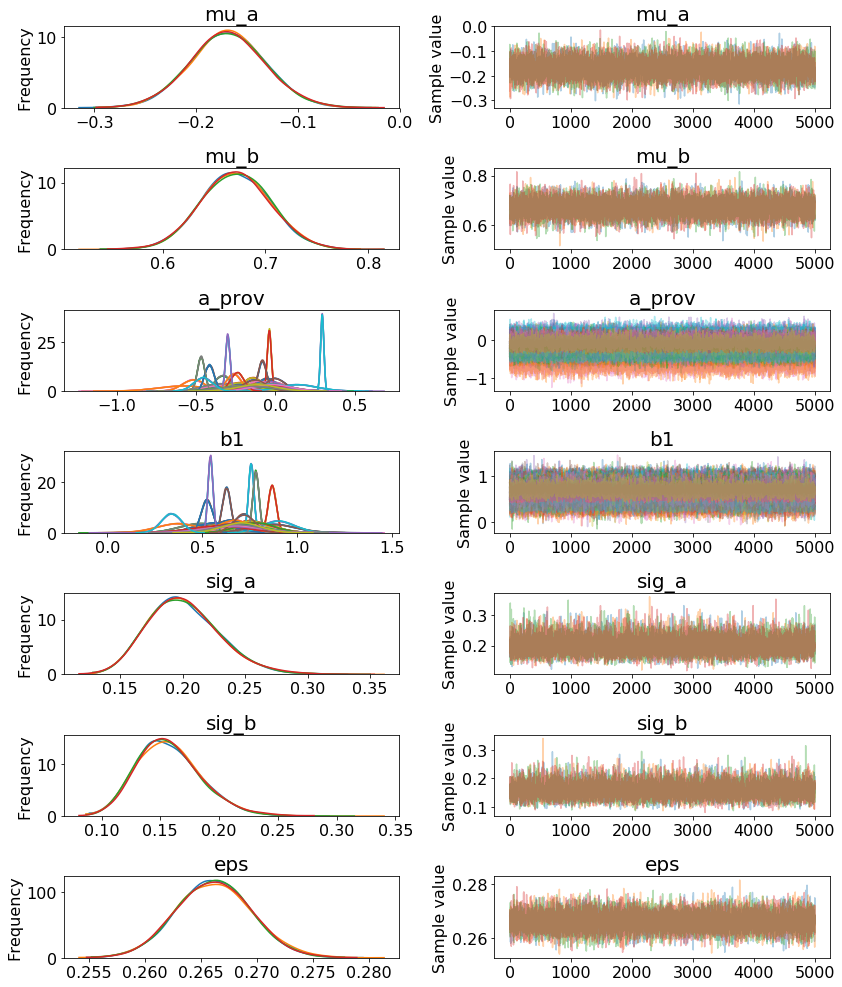

In [16]:
pm.traceplot(trace_m1ve);

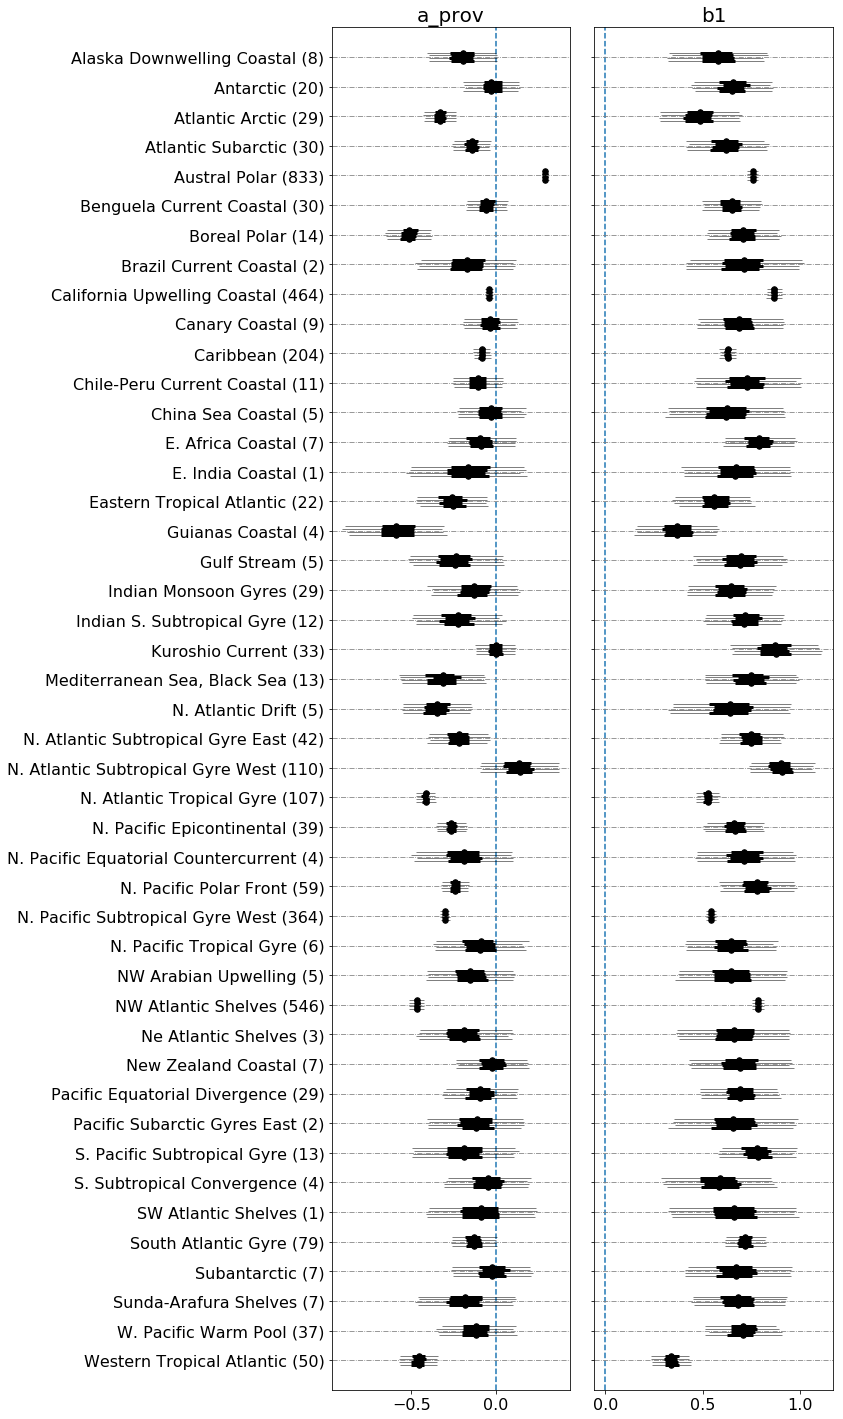

In [245]:
s_providx = df_pca_bn.ProvIdx
modified_forest_plot(trace_m1ve, varnames=['a_prov', 'b1'],
                     group_idcs=s_providx)

In [240]:
with pm.Model() as m2ve:
    "Varying slopes MLR on PC1 and PC2 only"
    mu_a = pm.Normal('mu_a', mu=0, sd=100)
    sig_a = pm.HalfCauchy('sig_a', 2.5)
    mu_b1 = pm.Normal('mu_b1', mu=0, sd=100)
    sig_b1 = pm.HalfCauchy('sig_b1', 2.5)
    mu_b2 = pm.Normal('mu_b2', mu=0, sd=100)
    sig_b2 = pm.HalfCauchy('sig_b2', 2.5)
    a_prov = pm.Normal('a_prov', mu=mu_a, sd=sig_a, shape=n_provinces)
    b1 = pm.Normal('b1', mu=mu_b1, sd=sig_b1, shape=n_provinces)
    b2 = pm.Normal('b2', mu=mu_b2, sd=sig_b2, shape=n_provinces)
    mu_log_chl = a_prov[provIdx] + b1[provIdx] * x_pc_s[0] \
                 + b2[provIdx] * x_pc_s[1]
    sigma_log_chl = pm.HalfNormal('eps', sd=5)
    log_chl = pm.Normal('log_chl', mu=mu_log_chl, sd=sigma_log_chl, observed=log_chl_obs)
    trace_m2ve = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b2, b1, a_prov, sig_b2_log__, mu_b2, sig_b1_log__, mu_b1, sig_a_log__, mu_a]
  3%|▎         | 323/10000 [00:09<04:57, 32.56it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [02:04<00:00, 80.37it/s]


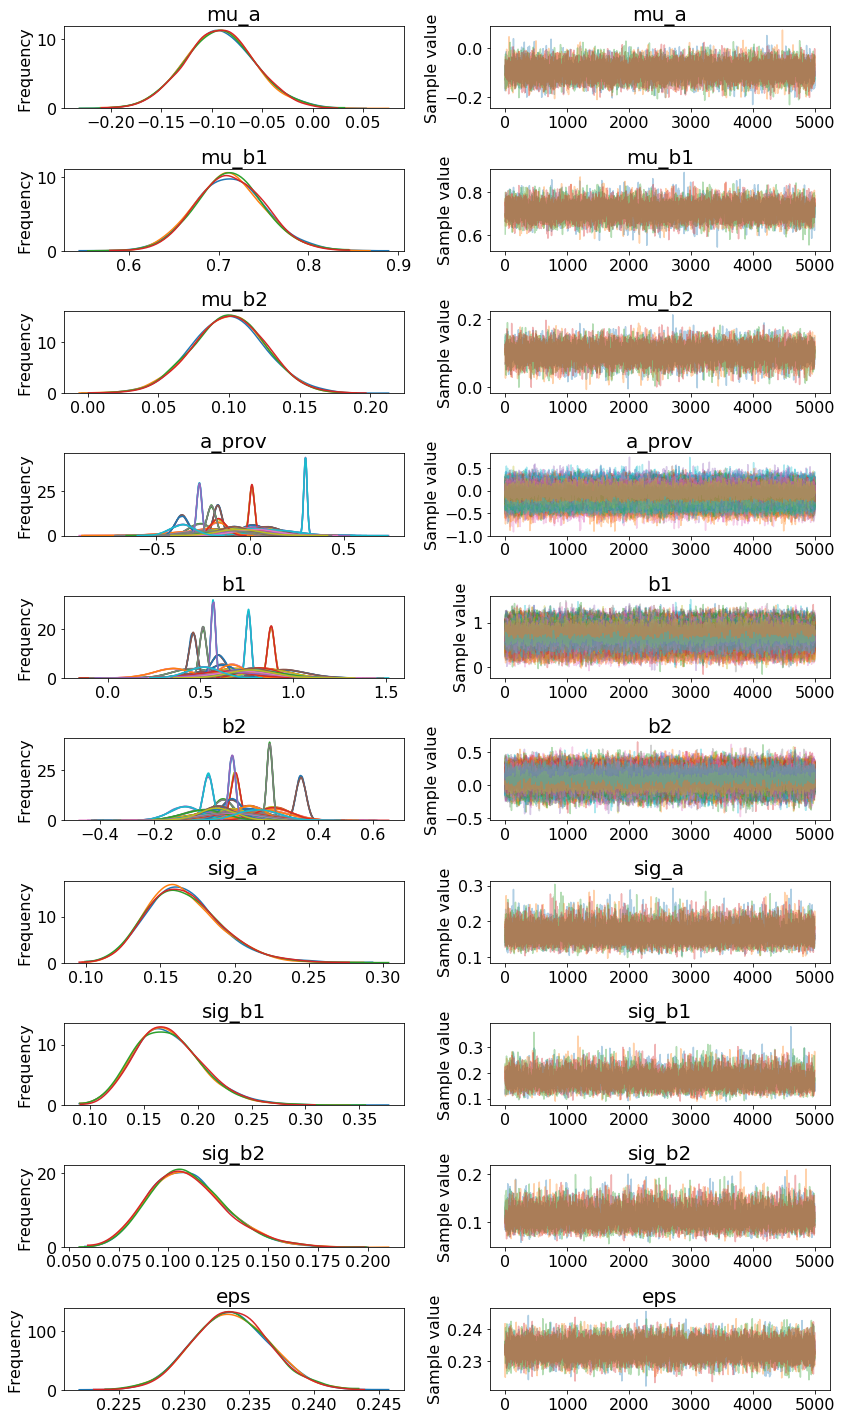

In [241]:
pm.traceplot(trace_m2ve);

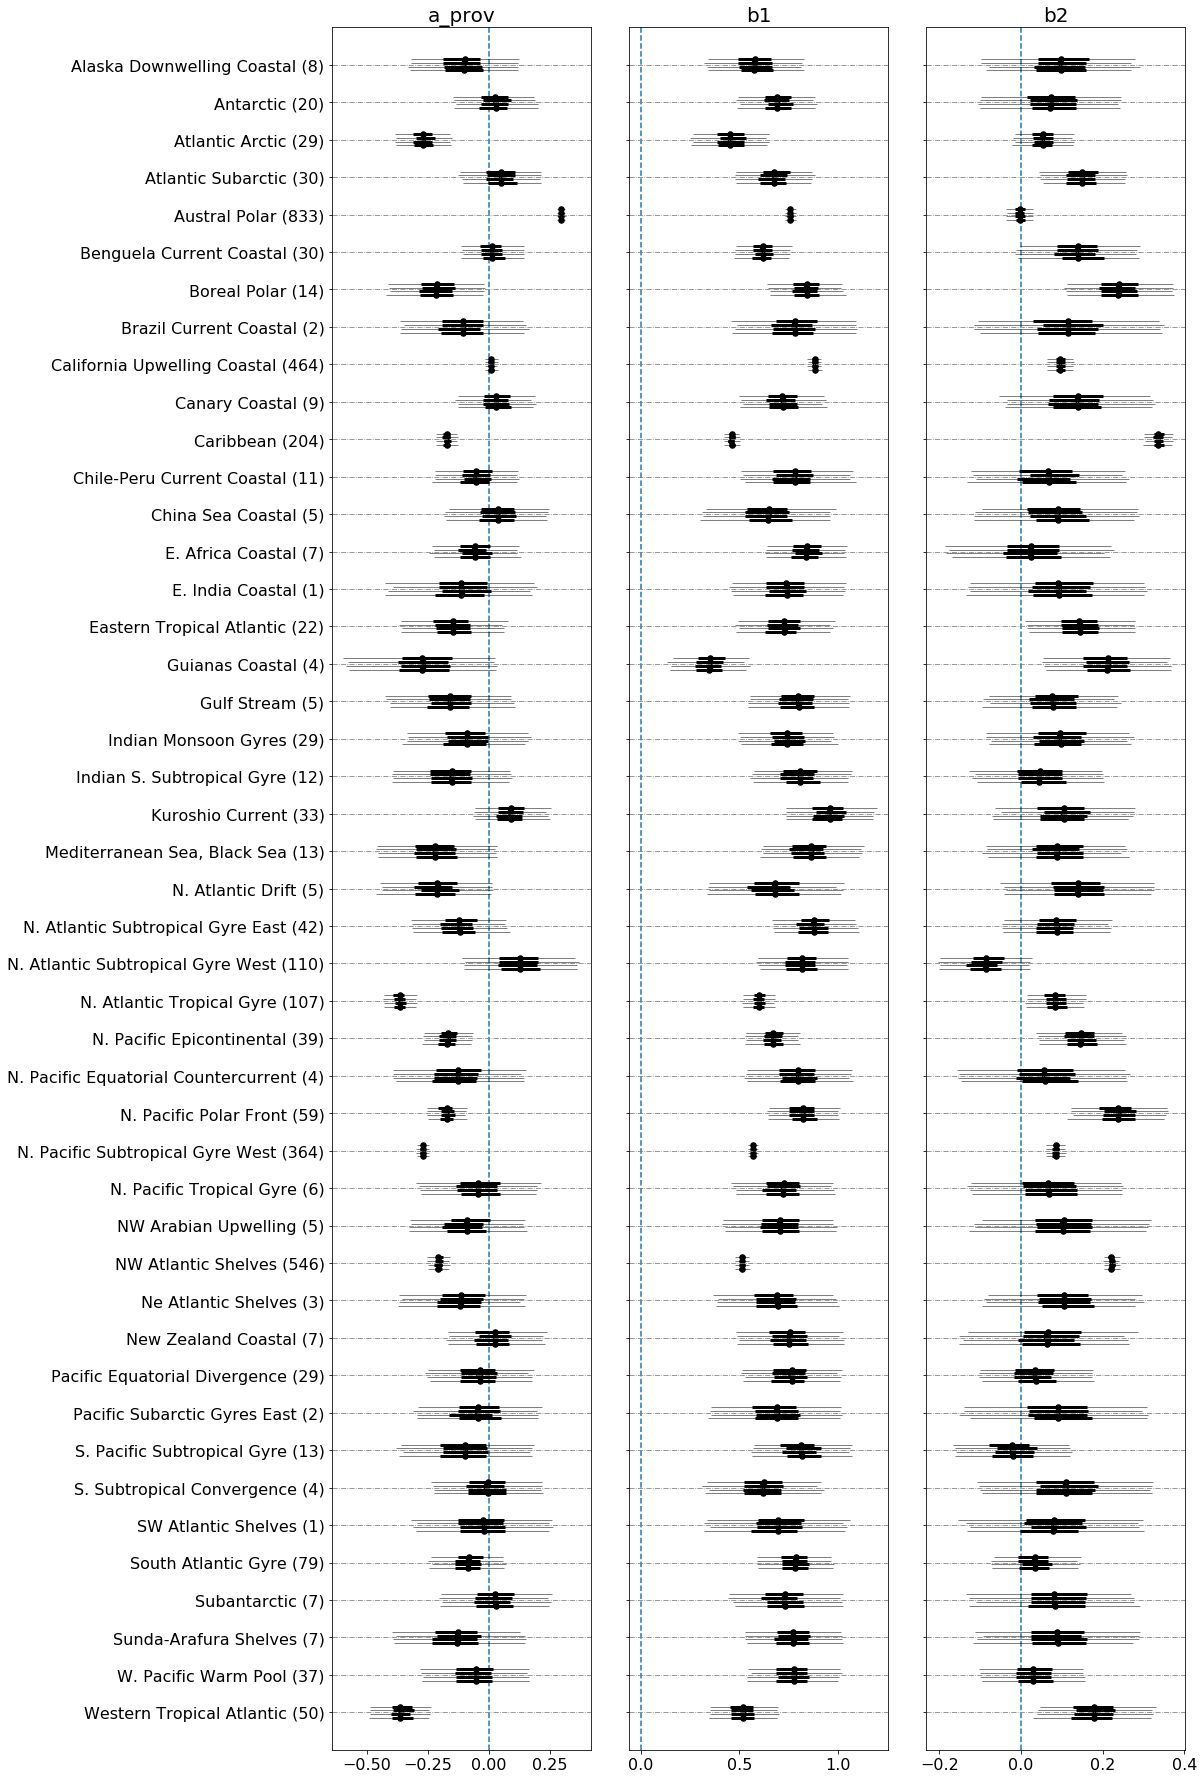

In [246]:
modified_forest_plot(trace_m2ve, varnames=['a_prov', 'b1', 'b2'],
                     group_idcs=s_providx, figsize=(17, 25))

In [177]:
with pm.Model() as m3_ve:
    "Varying slopes MLR on PC1 and PC2 only"
    mu_a = pm.Normal('mu_a', mu=0, sd=100)
    sig_a = pm.HalfCauchy('sig_a', 2.5)
    mu_b1 = pm.Normal('mu_b1', mu=0, sd=100)
    sig_b1 = pm.HalfCauchy('sig_b1', 2.5)
    mu_b2 = pm.Normal('mu_b2', mu=0, sd=100)
    sig_b2 = pm.HalfCauchy('sig_b2', 2.5)
    mu_b3 = pm.Normal('mu_b3', mu=0, sd=100)
    sig_b3 = pm.HalfCauchy('sig_b3', 2.5)
    a_prov = pm.Normal('a_prov', mu=mu_a, sd=sig_a, shape=n_provinces)
    b1 = pm.Normal('b1', mu=mu_b1, sd=sig_b1, shape=n_provinces)
    b2 = pm.Normal('b2', mu=mu_b2, sd=sig_b2, shape=n_provinces)
    b3 = pm.Normal('b3', mu=mu_b3, sd=sig_b3, shape=n_provinces)
    mu_log_chl = a_prov[provIdx] + b1[provIdx] * x_pc_s[0] \
                                 + b2[provIdx] * x_pc_s[1] \
                                 + b3[provIdx] * x_pc_s[2] 
    sigma_log_chl = pm.HalfNormal('eps', sd=5)
    log_chl = pm.Normal('log_chl', mu=mu_log_chl, sd=sigma_log_chl,
                        observed=log_chl_obs)
    trace_m3_ve = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b3, b2, b1, a_prov, sig_b3_log__, mu_b3, sig_b2_log__, mu_b2, sig_b1_log__, mu_b1, sig_a_log__, mu_a]
  3%|▎         | 301/10000 [00:09<05:20, 30.25it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [02:32<00:00, 65.64it/s]
The number of effective samples is smaller than 25% for some parameters.


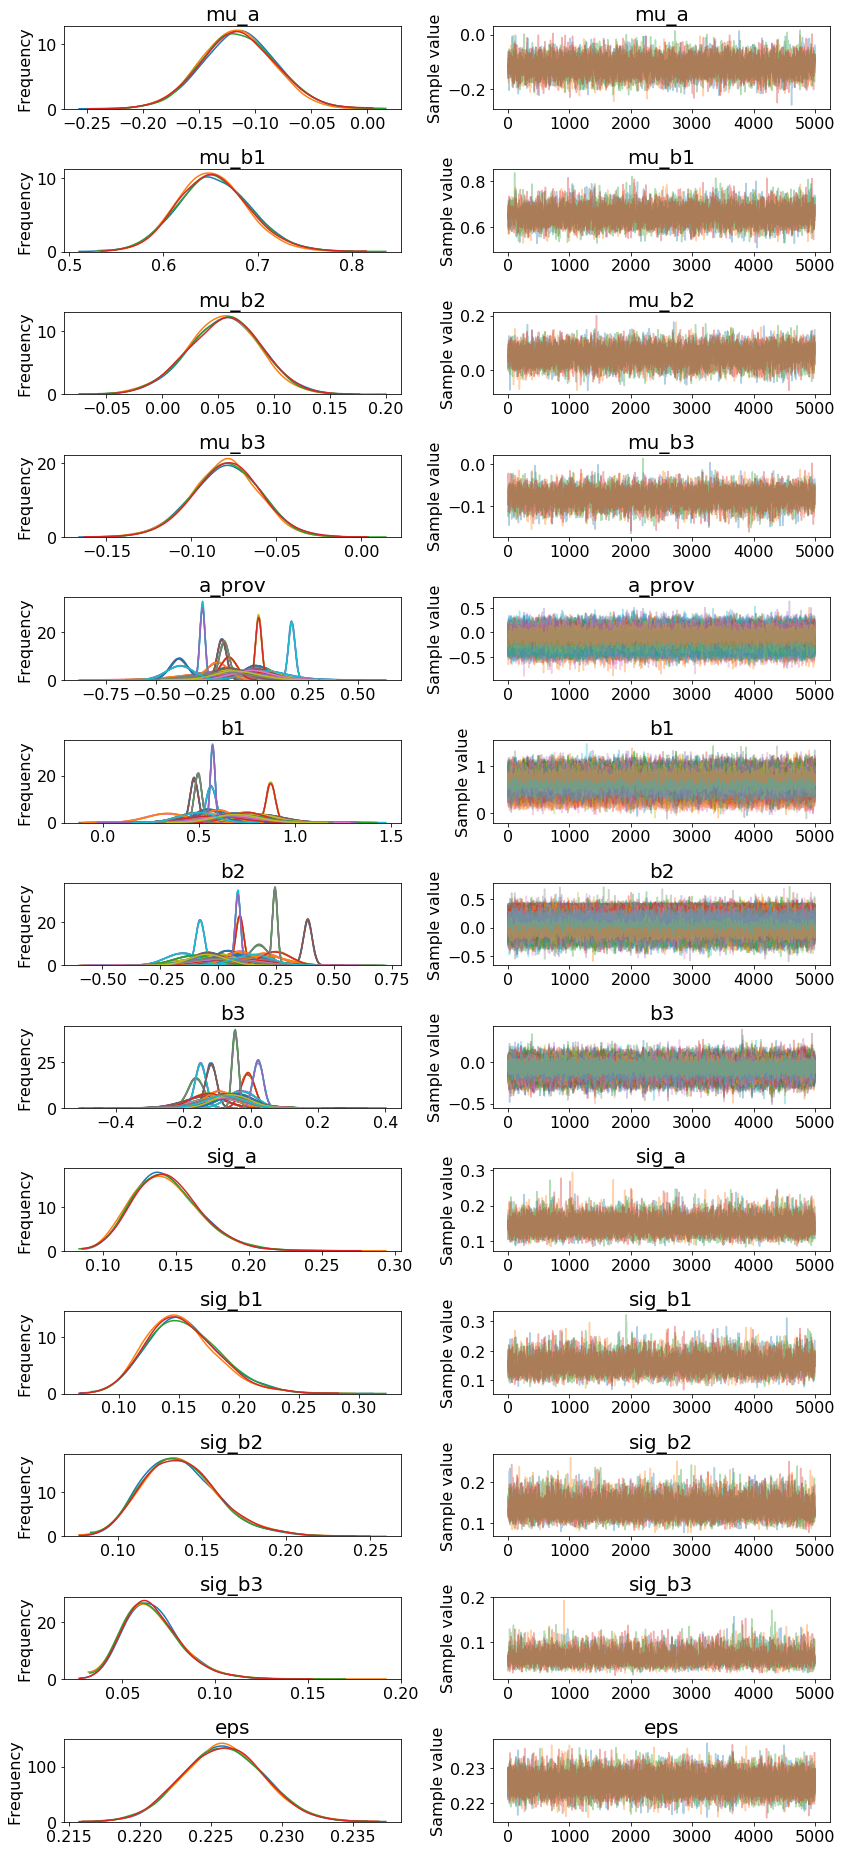

In [179]:
pm.traceplot(trace_m3_ve);

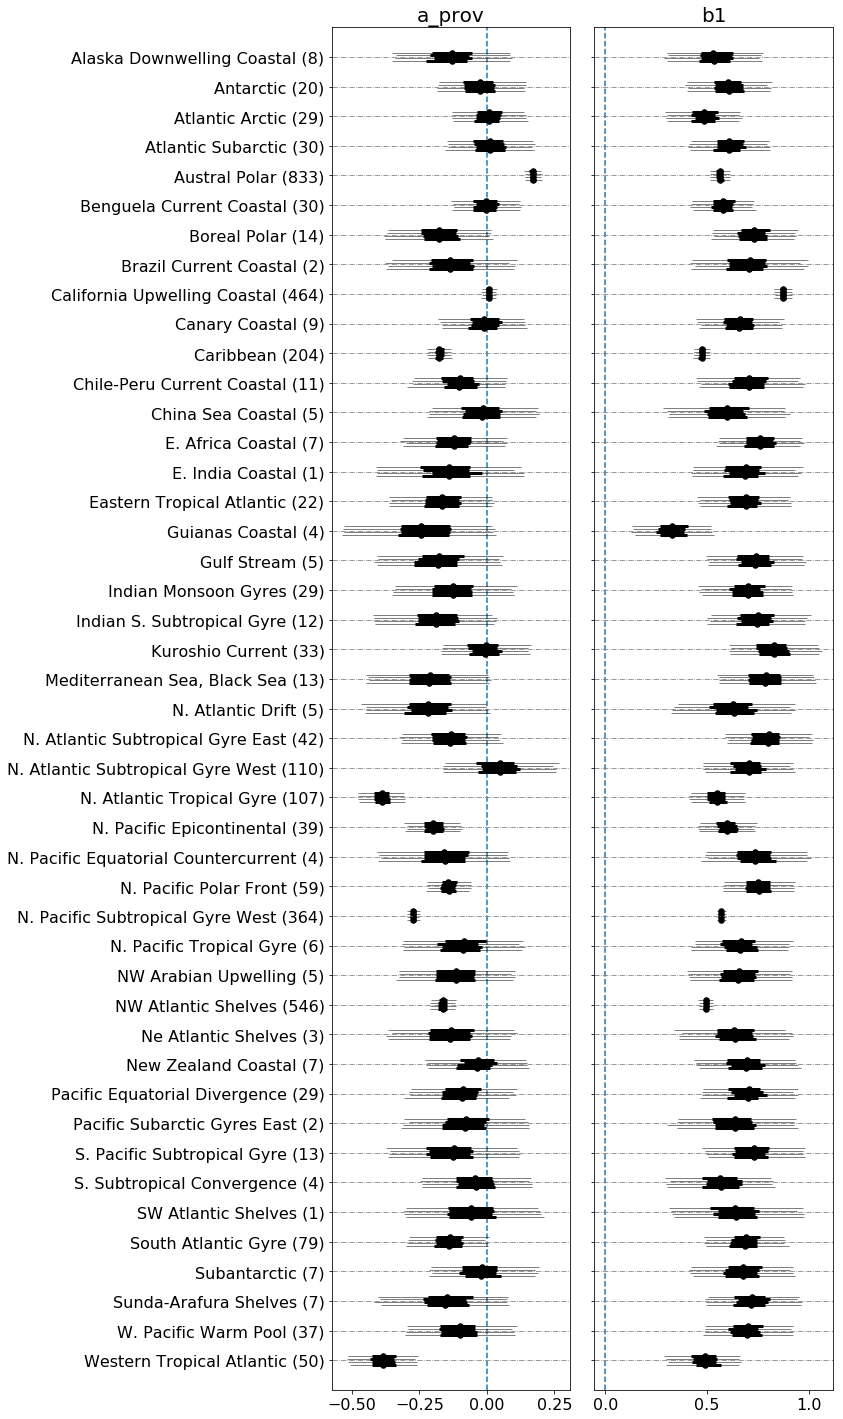

In [247]:
modified_forest_plot(trace_m3_ve, ['a_prov', 'b1'], s_providx)

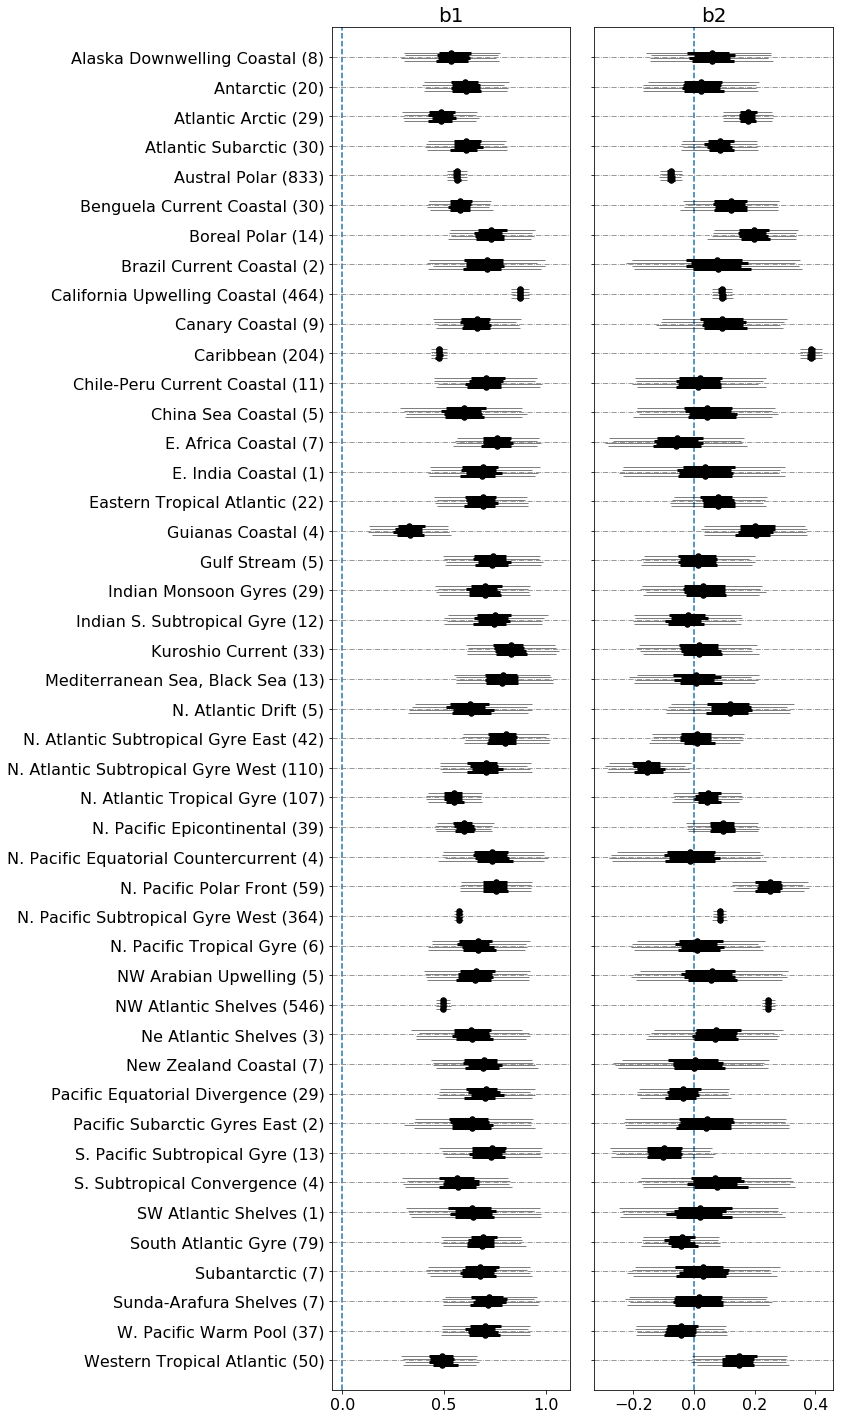

In [248]:
modified_forest_plot(trace_m3_ve, ['b1', 'b2'], s_providx)

In [259]:
with pm.Model() as m4:
    "Varying slopes MLR on PC1...4 only"
    mu_a = pm.Normal('mu_a', mu=0, sd=100)
    sig_a = pm.HalfCauchy('sig_a', 2.5)
    mu_b1 = pm.Normal('mu_b1', mu=0, sd=100)
    sig_b1 = pm.HalfCauchy('sig_b1', 2.5)
    mu_b2 = pm.Normal('mu_b2', mu=0, sd=100)
    sig_b2 = pm.HalfCauchy('sig_b2', 2.5)
    mu_b3 = pm.Normal('mu_b3', mu=0, sd=100)
    sig_b3 = pm.HalfCauchy('sig_b3', 2.5)
    mu_b4 = pm.Normal('mu_b4', mu=0, sd=100)
    sig_b4 = pm.HalfCauchy('sig_b4', 2.5)
    
    
    # begin -- NC segment
    a_offset = pm.Normal('a_offset', mu=0, sd=10, shape=n_provinces)
    b1_offset = pm.Normal('b1_offset', mu=0, sd=10, shape=n_provinces)
    b2_offset = pm.Normal('b2_offset', mu=0, sd=10, shape=n_provinces)
    b3_offset = pm.Normal('b3_offset', mu=0, sd=10, shape=n_provinces)
    b4_offset = pm.Normal('b4_offset', mu=0, sd=10, shape=n_provinces)
    
    a_prov = pm.Deterministic('a_prov', mu_a + a_offset * sig_a)
    b1 = pm.Deterministic('b1', mu_b1 + b1_offset * sig_b1)
    b2 = pm.Deterministic('b2', mu_b2 + b2_offset * sig_b2)
    b3 = pm.Deterministic('b3', mu_b3 + b3_offset * sig_b3)
    b4 = pm.Deterministic('b4', mu_b4 + b4_offset * sig_b4)
    # end -- NC segment
    # the below was commented out in favor of the NC segment above because of 
    # too few effective parameters.
    #a_prov = pm.Normal('a', mu=mu_a, sd=sig_a, shape=n_provinces)
    #b1 = pm.Normal('b1', mu=mu_b1, sd=sig_b1, shape=n_provinces)
    #b2 = pm.Normal('b2', mu=mu_b2, sd=sig_b2, shape=n_provinces)
    #b3 = pm.Normal('b3', mu=mu_b3, sd=sig_b3, shape=n_provinces)
    #b4 = pm.Normal('b4', mu=mu_b4, sd=sig_b4, shape=n_provinces)
    mu_log_chl = a_prov[provIdx] + b1[provIdx] * x_pc_s[0] \
                                 + b2[provIdx] * x_pc_s[1] \
                                 + b3[provIdx] * x_pc_s[2] \
                                 + b4[provIdx] * x_pc_s[3]
    sigma_log_chl = pm.HalfNormal('eps', sd=5)
    log_chl = pm.Normal('log_chl', mu=mu_log_chl, sd=sigma_log_chl,
                        observed=log_chl_obs)
    trace_m4 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b4_offset, b3_offset, b2_offset, b1_offset, a_offset, sig_b4_log__, mu_b4, sig_b3_log__, mu_b3, sig_b2_log__, mu_b2, sig_b1_log__, mu_b1, sig_a_log__, mu_a]
  1%|          | 84/10000 [00:09<19:32,  8.45it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [05:58<00:00, 27.89it/s]


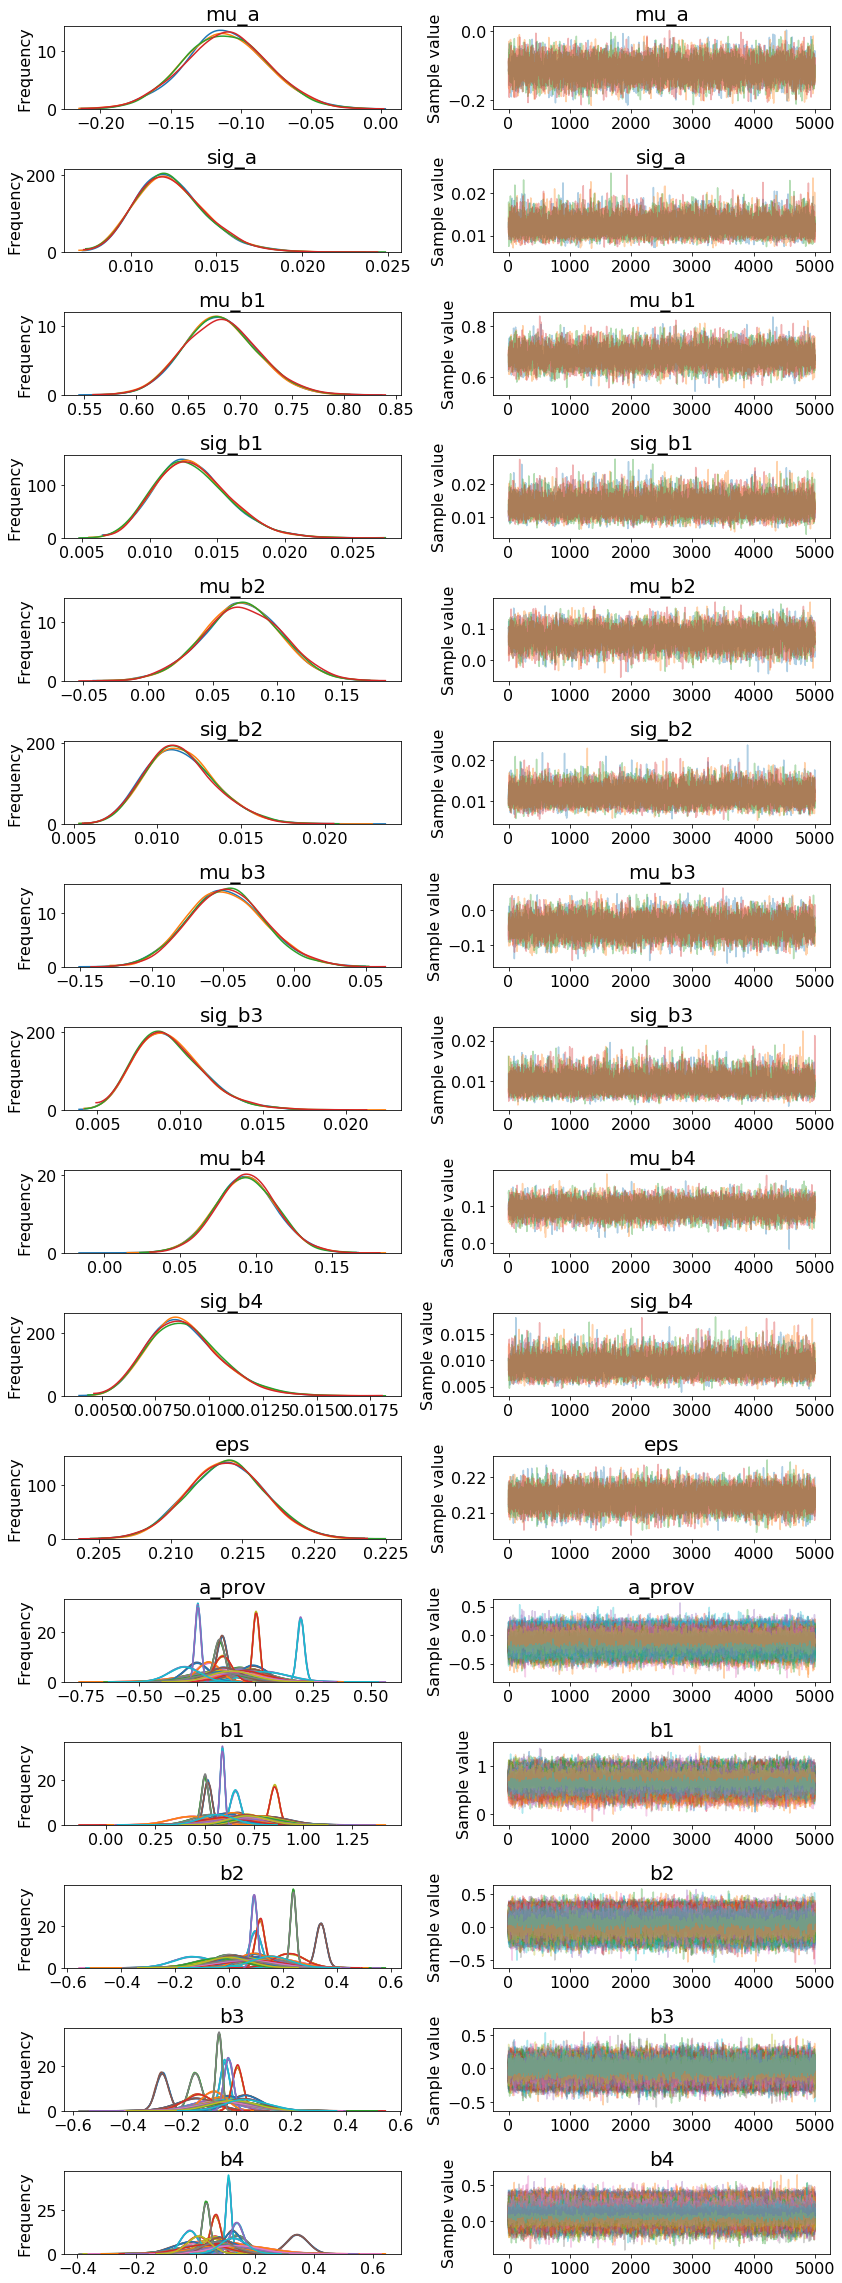

In [260]:
pm.traceplot(trace_m4, varnames=['mu_a', 'sig_a', 'mu_b1', 'sig_b1', 'mu_b2', 'sig_b2',
                                'mu_b3', 'sig_b3', 'mu_b4', 'sig_b4', 'eps',
                                'a_prov', 'b1', 'b2' ,'b3', 'b4']);

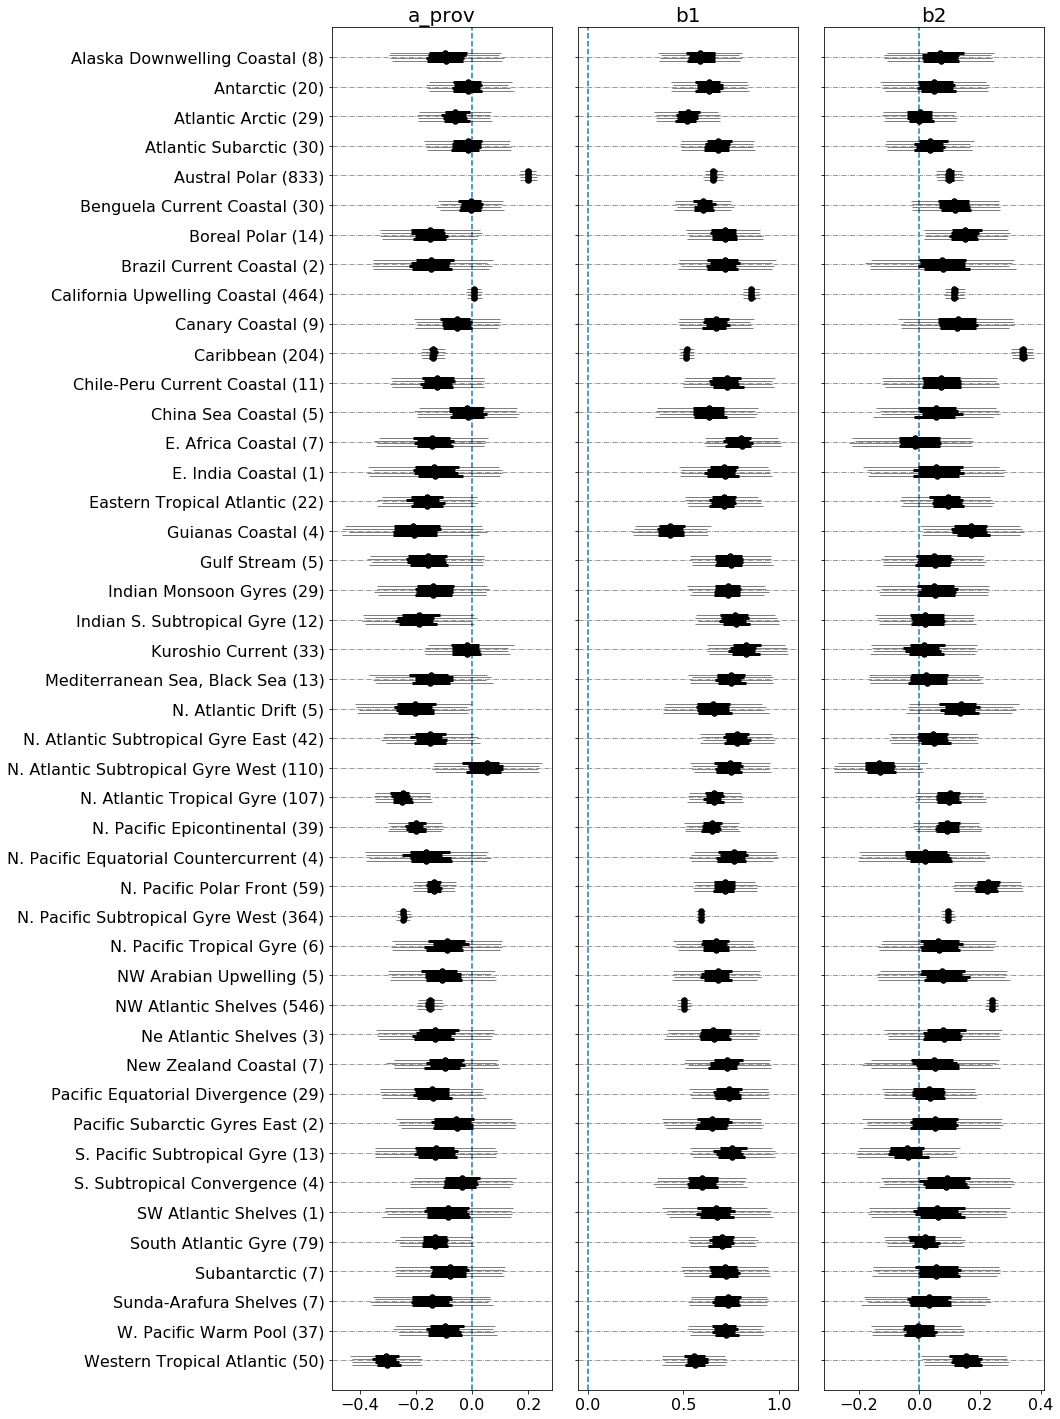

In [261]:
modified_forest_plot(trace_m4, ['a_prov', 'b1', 'b2'], s_providx)

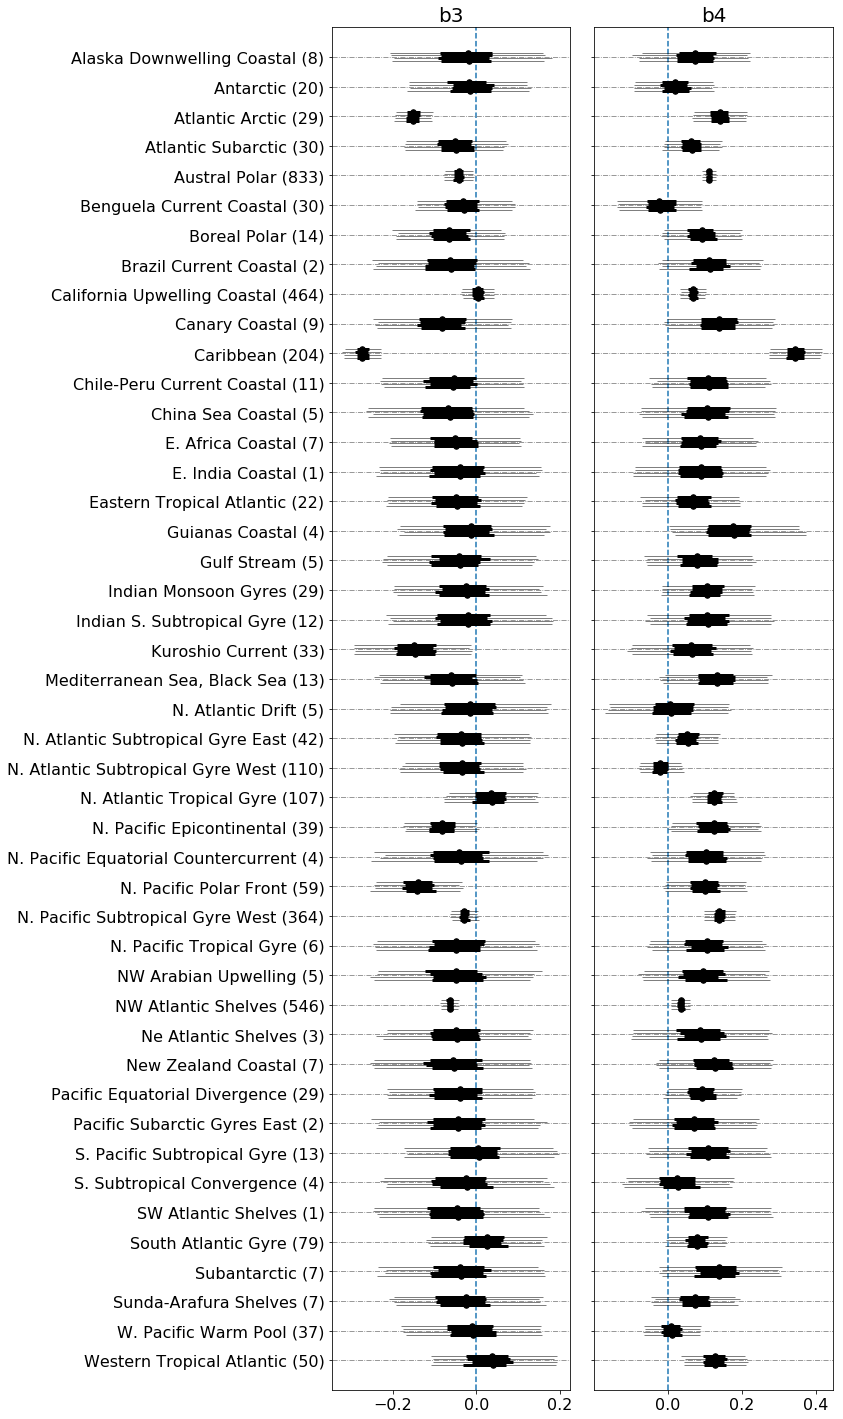

In [262]:
modified_forest_plot(trace_m4, ['b3', 'b4'], s_providx)

In [264]:
with pm.Model() as m5:
    "Varying slopes MLR on PC1... 5"
    mu_a = pm.Normal('mu_a', mu=0, sd=100)
    sig_a = pm.HalfCauchy('sig_a', 2.5)
    mu_b1 = pm.Normal('mu_b1', mu=0, sd=100)
    sig_b1 = pm.HalfCauchy('sig_b1', 2.5)
    mu_b2 = pm.Normal('mu_b2', mu=0, sd=100)
    sig_b2 = pm.HalfCauchy('sig_b2', 2.5)
    mu_b3 = pm.Normal('mu_b3', mu=0, sd=100)
    sig_b3 = pm.HalfCauchy('sig_b3', 2.5)
    mu_b4 = pm.Normal('mu_b4', mu=0, sd=100)
    sig_b4 = pm.HalfCauchy('sig_b4', 2.5)
    mu_b5 = pm.Normal('mu_b5', mu=0, sd=100)
    sig_b5  =pm.HalfCauchy('sig_b5', 2.5)
    
    a_offset = pm.Normal('a_offset', mu=0, sd=10, shape=n_provinces)
    b1_offset = pm.Normal('b1_offset', mu=0, sd=10, shape=n_provinces)
    b2_offset = pm.Normal('b2_offset', mu=0, sd=10, shape=n_provinces)
    b3_offset = pm.Normal('b3_offset', mu=0, sd=10, shape=n_provinces)
    b4_offset = pm.Normal('b4_offset', mu=0, sd=10, shape=n_provinces)
    b5_offset = pm.Normal('b5_offset', mu=0, sd=10, shape=n_provinces)
    
    a_prov = pm.Deterministic('a_prov', mu_a + a_offset * sig_a)
    b1 = pm.Deterministic('b1', mu_b1 + b1_offset * sig_b1)
    b2 = pm.Deterministic('b2', mu_b2 + b2_offset * sig_b2)
    b3 = pm.Deterministic('b3', mu_b3 + b3_offset * sig_b3)
    b4 = pm.Deterministic('b4', mu_b4 + b4_offset * sig_b4)
    b5 = pm.Deterministic('b5', mu_b5 + b5_offset * sig_b5)
    
    #a_prov = pm.Normal('a_prov', mu=mu_a, sd=sig_a, shape=n_provinces)
    #b1 = pm.Normal('b1', mu=mu_b1, sd=sig_b1, shape=n_provinces)
    #b2 = pm.Normal('b2', mu=mu_b2, sd=sig_b2, shape=n_provinces)
    #b3 = pm.Normal('b3', mu=mu_b3, sd=sig_b3, shape=n_provinces)
    #b4 = pm.Normal('b4', mu=mu_b4, sd=sig_b4, shape=n_provinces)
    #b5 = pm.Normal('b5', mu=mu_b5, sd=sig_b5, shape=n_provinces)
    mu_log_chl = a_prov[provIdx] + b1[provIdx] * x_pc_s[0] \
                                 + b2[provIdx] * x_pc_s[1] \
                                 + b3[provIdx] * x_pc_s[2] \
                                 + b4[provIdx] * x_pc_s[3] \
                                 + b5[provIdx] * x_pc_s[4]
    sigma_log_chl = pm.HalfNormal('eps', sd=5)
    log_chl = pm.Normal('log_chl', mu=mu_log_chl, sd=sigma_log_chl,
                        observed=log_chl_obs)
    trace_m5 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b5_offset, b4_offset, b3_offset, b2_offset, b1_offset, a_offset, sig_b5_log__, mu_b5, sig_b4_log__, mu_b4, sig_b3_log__, mu_b3, sig_b2_log__, mu_b2, sig_b1_log__, mu_b1, sig_a_log__, mu_a]
  1%|          | 65/10000 [00:09<25:13,  6.56it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [07:00<00:00, 23.76it/s]


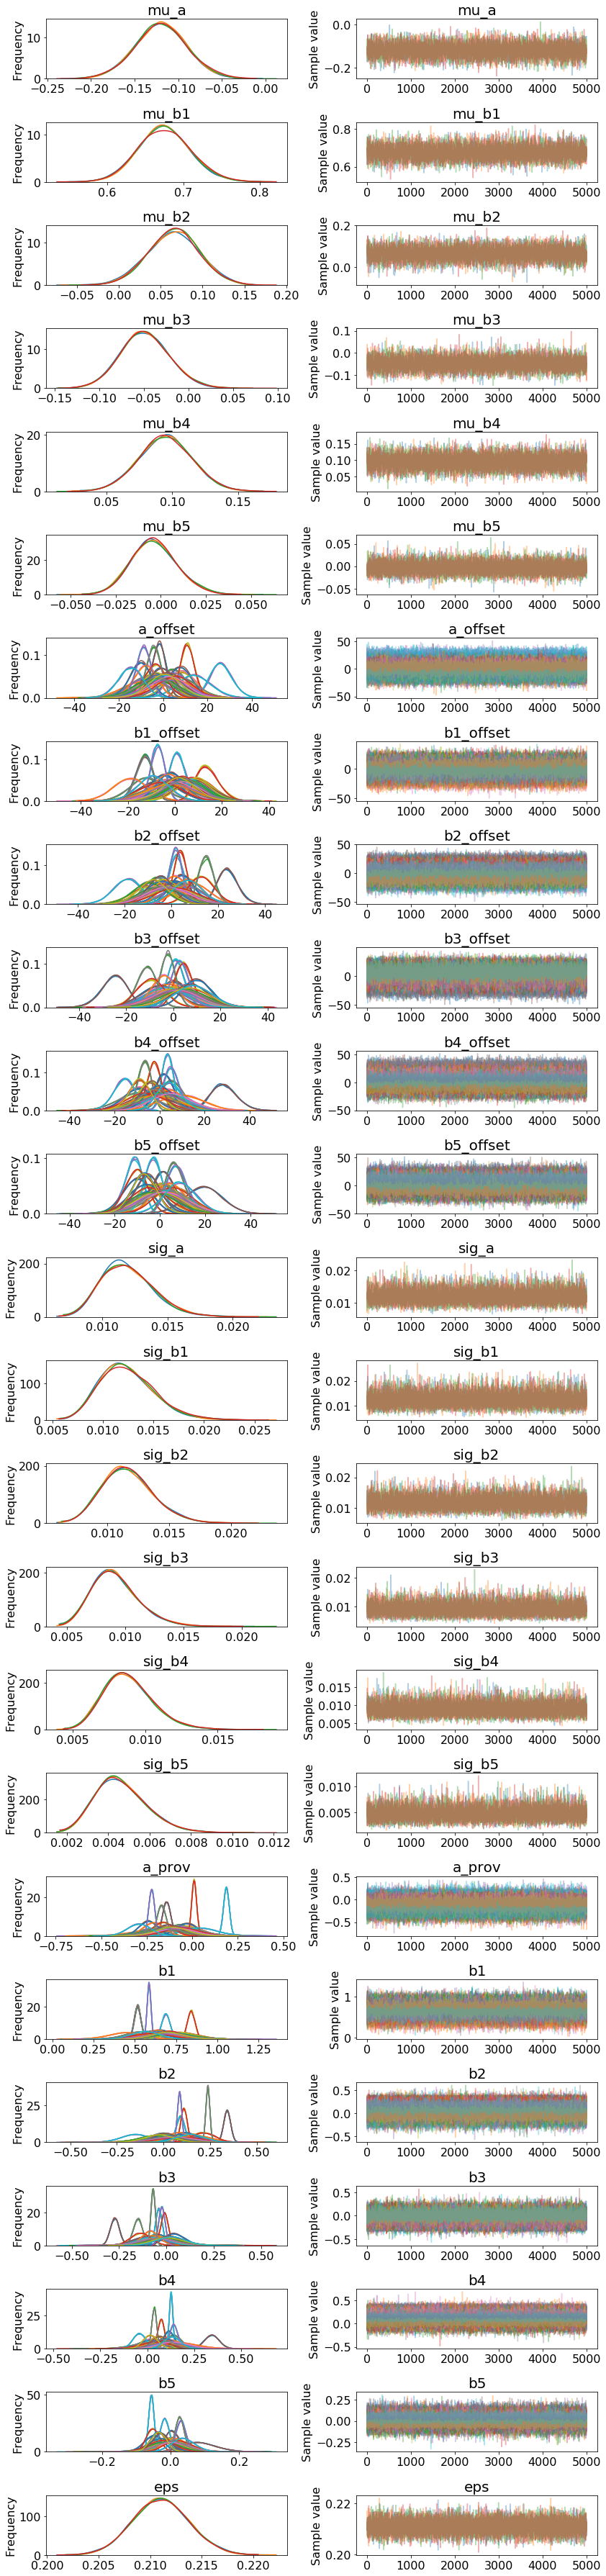

In [265]:
pm.traceplot(trace_m5);

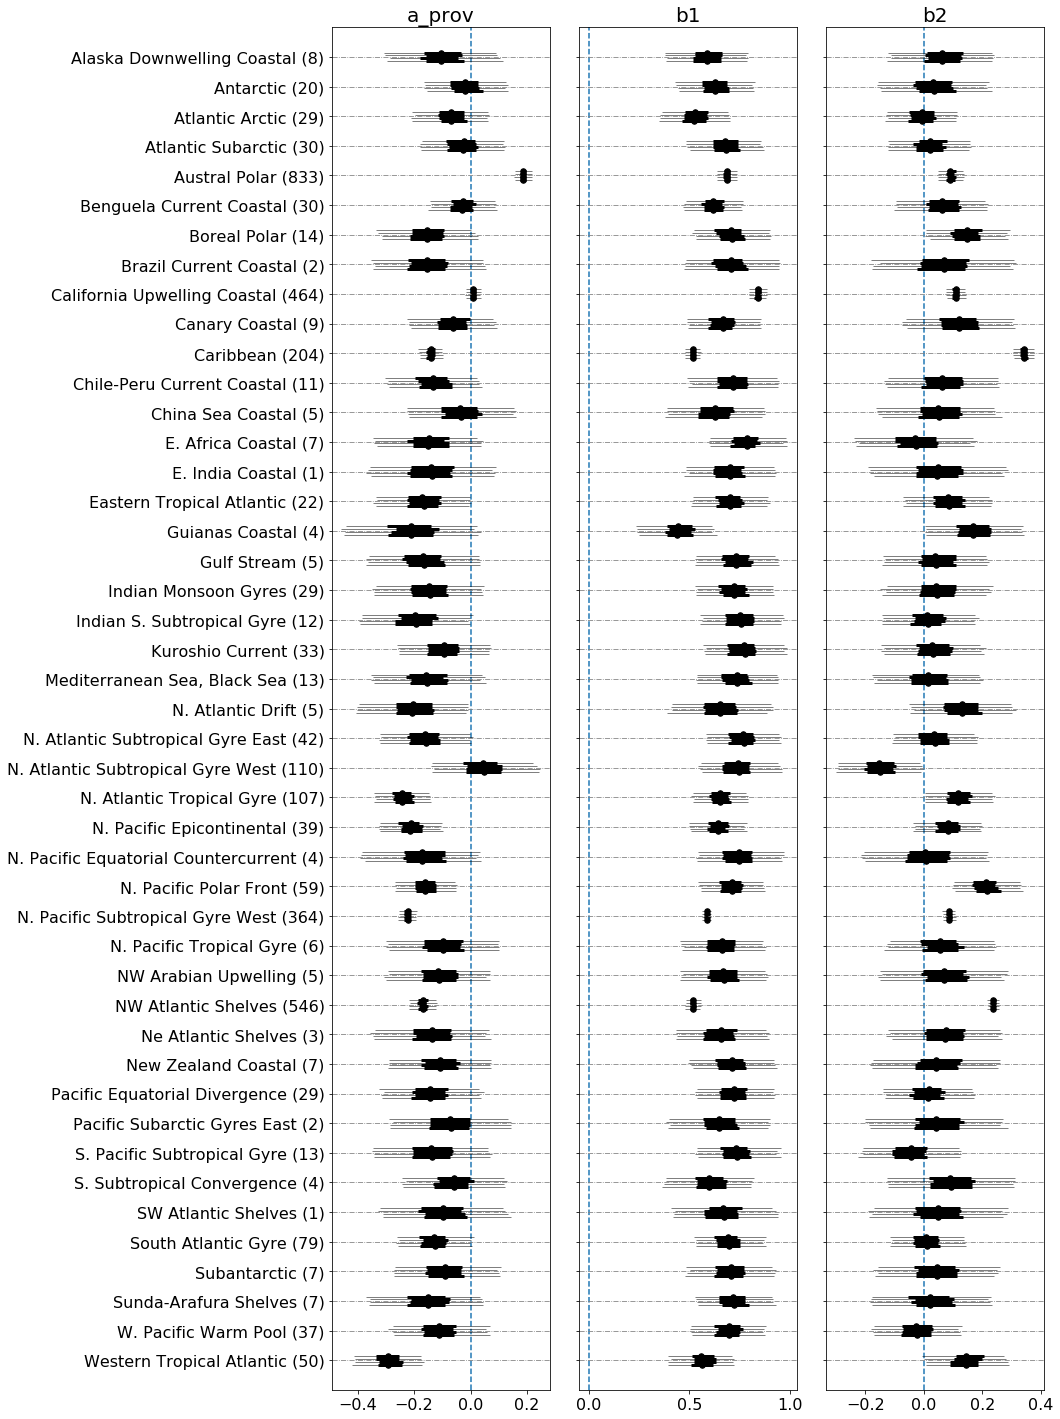

In [267]:
modified_forest_plot(trace_m5, varnames=['a_prov', 'b1', 'b2'], group_idcs=s_providx)

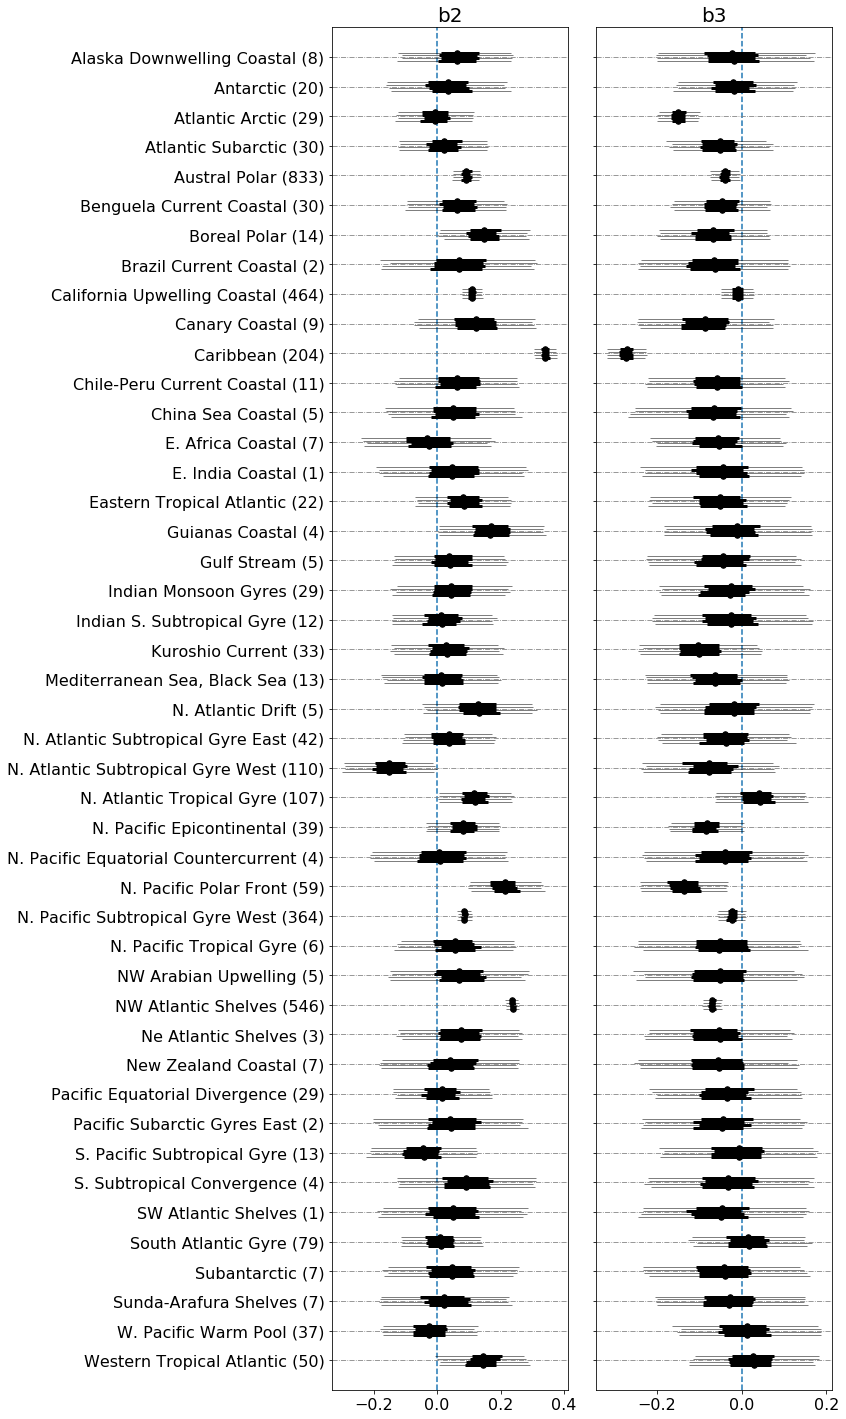

In [269]:
modified_forest_plot(trace_m5, varnames=['b2', 'b3'], group_idcs=s_providx)

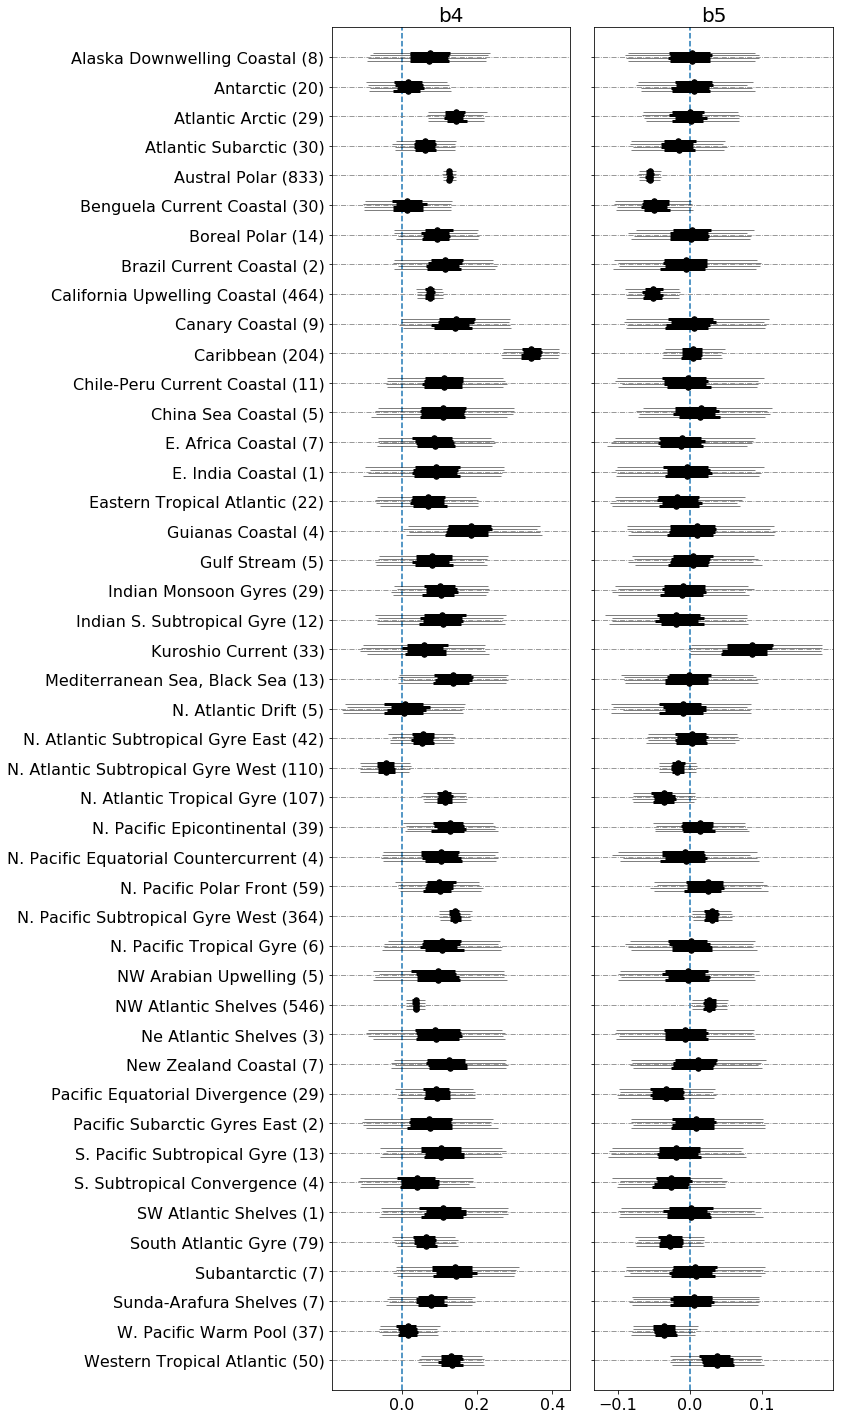

In [271]:
modified_forest_plot(trace_m5, ['b4', 'b5'], group_idcs=s_providx)

In [272]:
with pm.Model() as m6:
    """Hierarchical MLR with varying slope"""
    # hyperpriors
    
    mu_a = pm.Normal('mu_a', 0, sd=100)
    mu_b1 = pm.Normal('mu_b1', 0, sd=100)
    mu_b2 = pm.Normal('mu_b2', 0, sd=100)
    mu_b3 = pm.Normal('mu_b3', 0, sd=100)
    mu_b4 = pm.Normal('mu_b4', 0, sd=100)
    mu_b5 = pm.Normal('mu_b5', 0, sd=100)
    mu_b6 = pm.Normal('mu_b6', 0, sd=100)
    sig_a = pm.HalfCauchy('sig_a', 2.5)
    sig_b1 = pm.HalfCauchy('sig_b1', 2.5)
    sig_b2 = pm.HalfCauchy('sig_b2', 2.5)
    sig_b3 = pm.HalfCauchy('sig_b3', 2.5)
    sig_b4 = pm.HalfCauchy('sig_b4', 2.5)
    sig_b5 = pm.HalfCauchy('sig_b5', 2.5)
    sig_b6 = pm.HalfCauchy('sig_b6', 2.5)
    
    a_offset = pm.Normal('a_offset', mu=0, sd=10, shape=n_provinces)
    b1_offset = pm.Normal('b1_offset', mu=0, sd=10, shape=n_provinces)
    b2_offset = pm.Normal('b2_offset', mu=0, sd=10, shape=n_provinces)
    b3_offset = pm.Normal('b3_offset', mu=0, sd=10, shape=n_provinces)
    b4_offset = pm.Normal('b4_offset', mu=0, sd=10, shape=n_provinces)
    b5_offset = pm.Normal('b5_offset', mu=0, sd=10, shape=n_provinces)
    b6_offset = pm.Normal('b6_offset', mu=0, sd=10, shape=n_provinces)
    
    a_prov = pm.Deterministic('a_prov', mu_a + a_offset * sig_a)
    b1 = pm.Deterministic('b1', mu_b1 + b1_offset * sig_b1)
    b2 = pm.Deterministic('b2', mu_b2 + b2_offset * sig_b2)
    b3 = pm.Deterministic('b3', mu_b3 + b3_offset * sig_b3)
    b4 = pm.Deterministic('b4', mu_b4 + b4_offset * sig_b4)
    b5 = pm.Deterministic('b5', mu_b5 + b5_offset * sig_b5)
    b6 = pm.Deterministic('b6', mu_b6 + b6_offset * sig_b6)
    
    #a_prov = pm.Normal('a_prov', mu=mu_a, sd=sig_a)
    #b1 = pm.Normal('b1', mu=mu_b1, sd=sig_b1, shape=n_provinces)
    #b2 = pm.Normal('b2', mu=mu_b2, sd=sig_b2, shape=n_provinces)
    #b3 = pm.Normal('b3', mu=mu_b3, sd=sig_b3, shape=n_provinces)
    #b4 = pm.Normal('b4', mu=mu_b4, sd=sig_b4, shape=n_provinces)
    #b5 = pm.Normal('b5', mu=mu_b5, sd=sig_b5, shape=n_provinces)
    #b6 = pm.Normal('b6', mu=mu_b6, sd=sig_b6, shape=n_provinces)
    mu_log_chl = a_prov[provIdx] + b1[provIdx] * x_pc_s[0] \
                                 + b2[provIdx] * x_pc_s[1] \
                                 + b3[provIdx] * x_pc_s[2] \
                                 + b4[provIdx] * x_pc_s[3] \
                                 + b5[provIdx] * x_pc_s[4] \
                                 + b6[provIdx] * x_pc_s[5]
    sigma_log_chl = pm.HalfNormal('eps', sd=5)
    log_chl = pm.Normal('log_chl', mu=mu_log_chl, sd=sigma_log_chl,
                        observed=log_chl_obs)
    trace_m6 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b6_offset, b5_offset, b4_offset, b3_offset, b2_offset, b1_offset, a_offset, sig_b6_log__, sig_b5_log__, sig_b4_log__, sig_b3_log__, sig_b2_log__, sig_b1_log__, sig_a_log__, mu_b6, mu_b5, mu_b4, mu_b3, mu_b2, mu_b1, mu_a]
  1%|          | 61/10000 [00:09<26:52,  6.16it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [08:47<00:00, 18.94it/s]


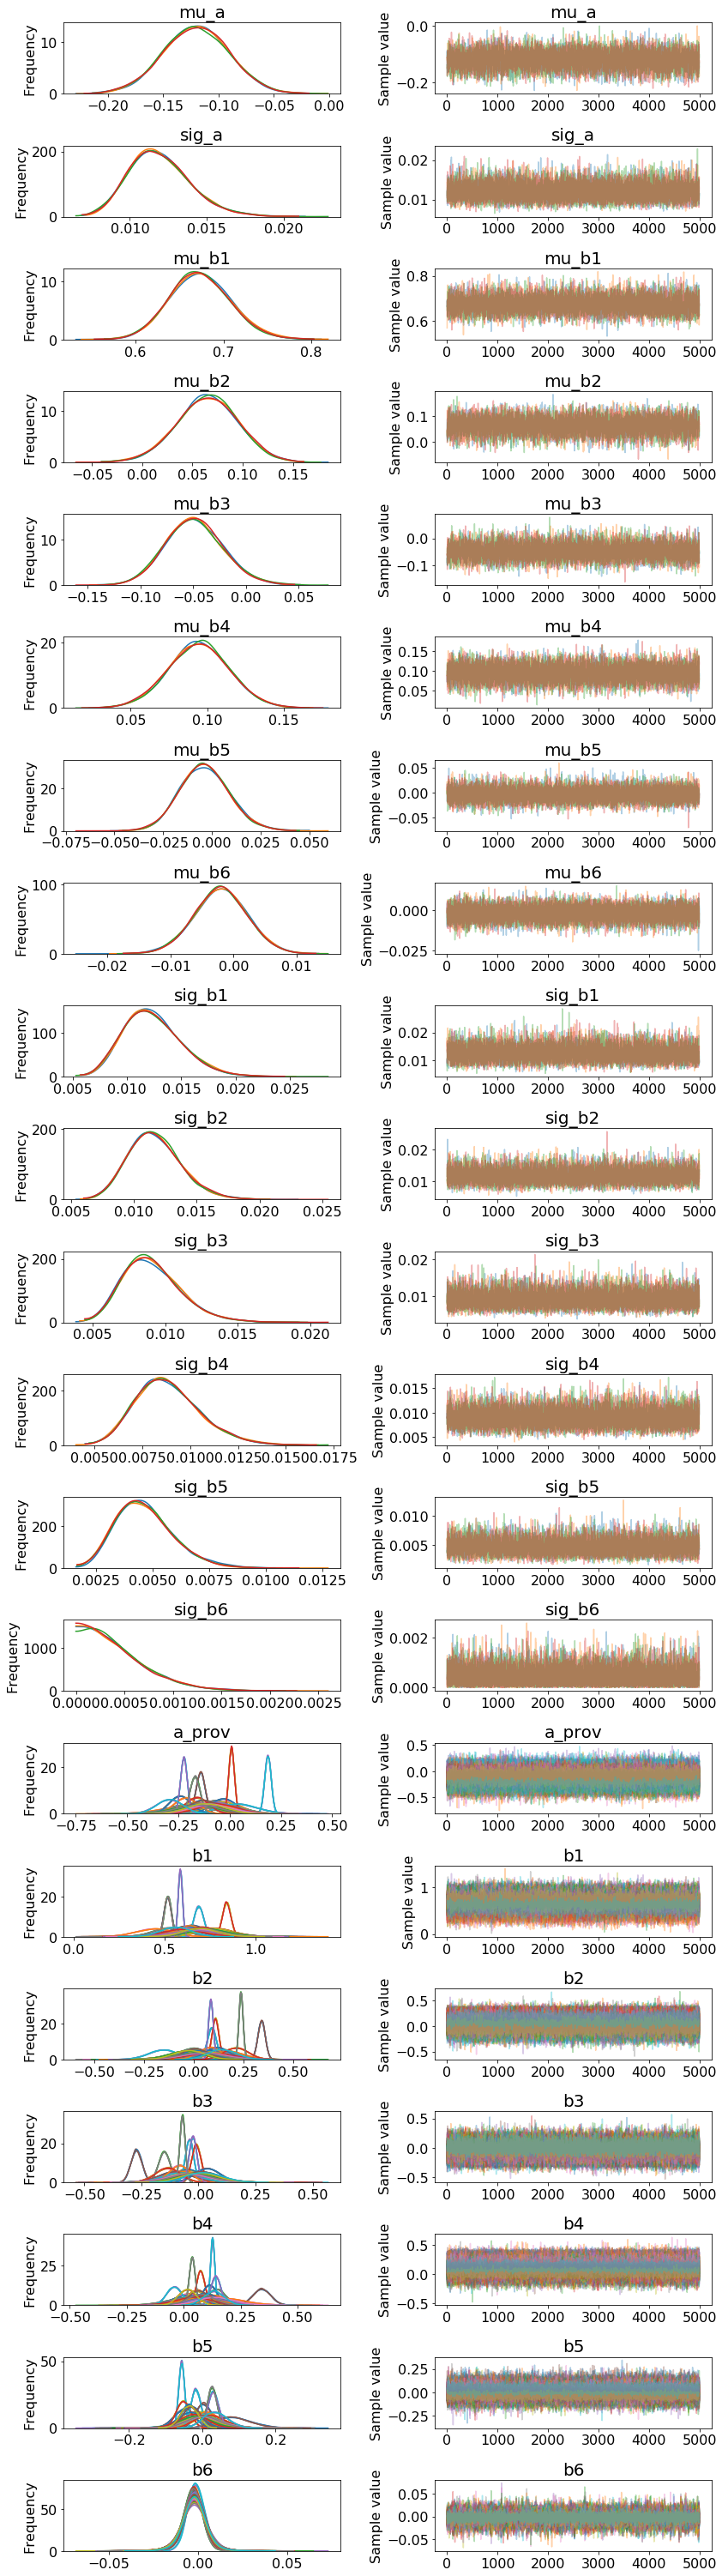

In [274]:
pm.traceplot(trace_m6, varnames=['mu_a', 'sig_a'] + ['mu_b%d' %i for i in range(1, 7)]
            + ['sig_b%d' % i for i in range(1, 7)] + ['a_prov'] 
            + ['b%d' %i for i in range(1, 7)]);

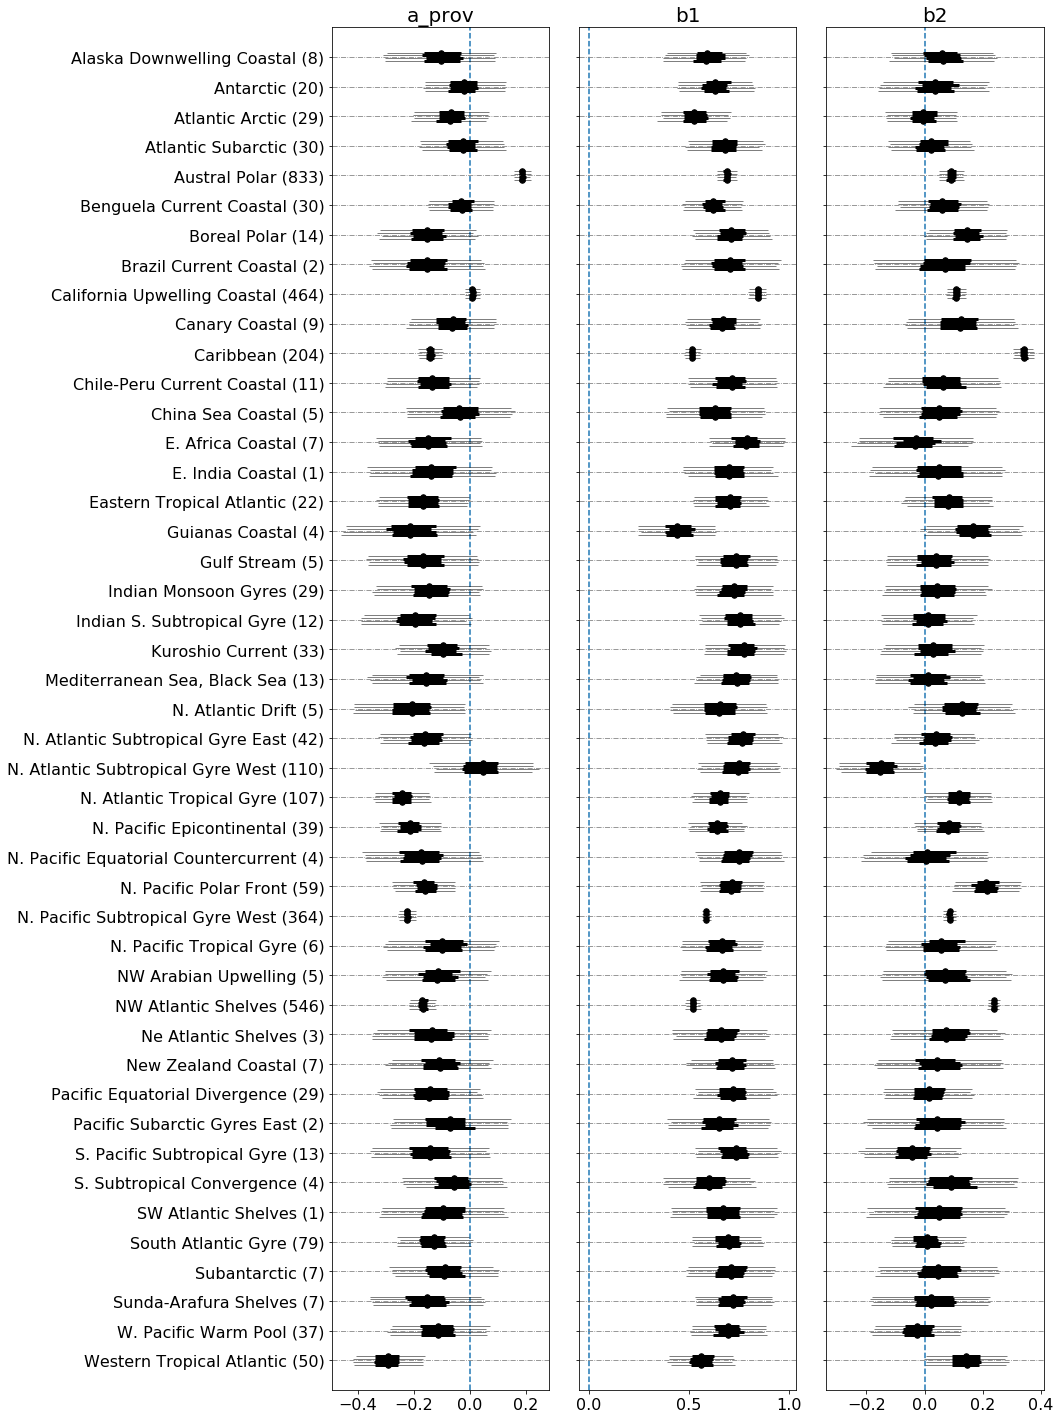

In [277]:
modified_forest_plot(trace_m6, varnames=['a_prov', 'b1', 'b2'], group_idcs=s_providx)

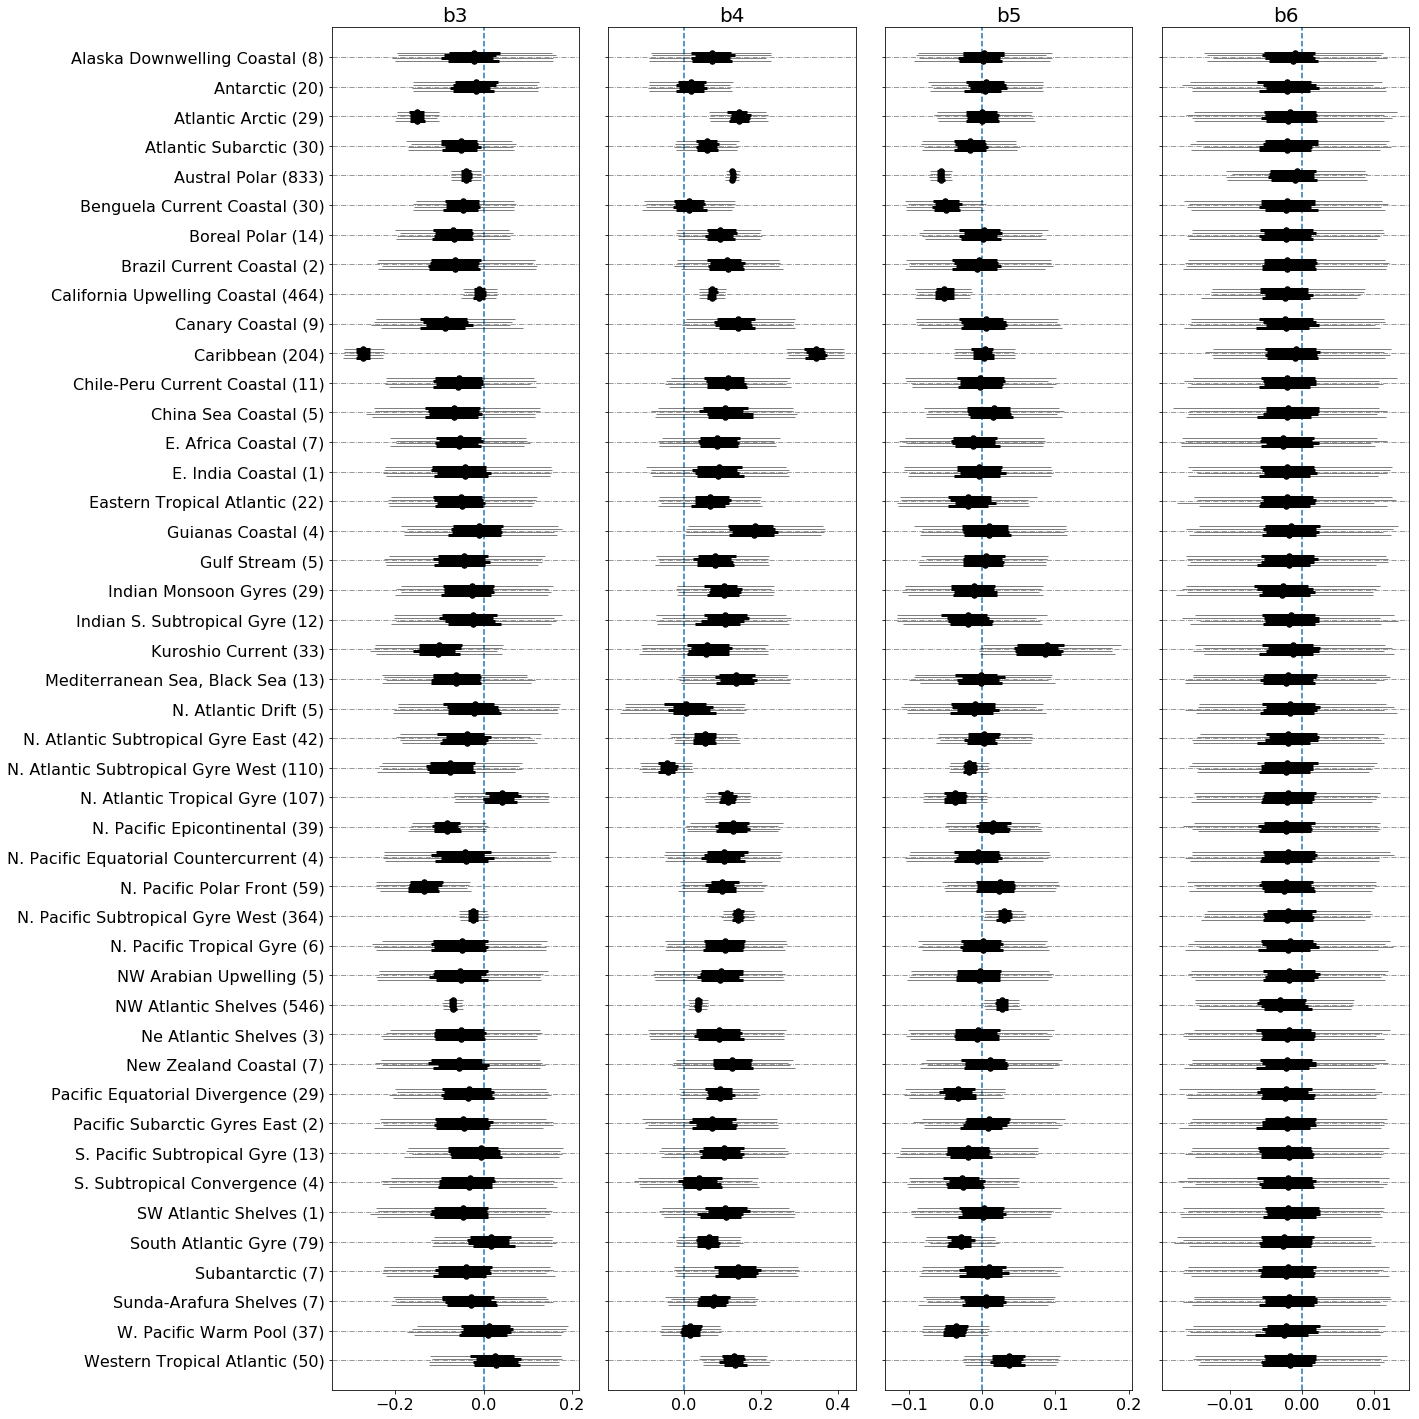

In [279]:
modified_forest_plot(trace_m6, varnames=['b3', 'b4', 'b5', 'b6'], group_idcs=s_providx)

In [280]:
ppc_dict = {}
ppc_dict['m1'] = pm.sample_ppc(trace_m1, samples=1000, model=m1)['log_chl']
ppc_dict['m2'] = pm.sample_ppc(trace_m2, samples=1000, model=m2)['log_chl']
ppc_dict['m3'] = pm.sample_ppc(trace_m3, samples=1000, model=m3)['log_chl']
ppc_dict['m4'] = pm.sample_ppc(trace_m4, samples=1000, model=m4)['log_chl']
ppc_dict['m5'] = pm.sample_ppc(trace_m5, samples=1000, model=m5)['log_chl']
ppc_dict['m6'] = pm.sample_ppc(trace_m6, samples=1000, model=m6)['log_chl']

NameError: name 'trace_m1' is not defined

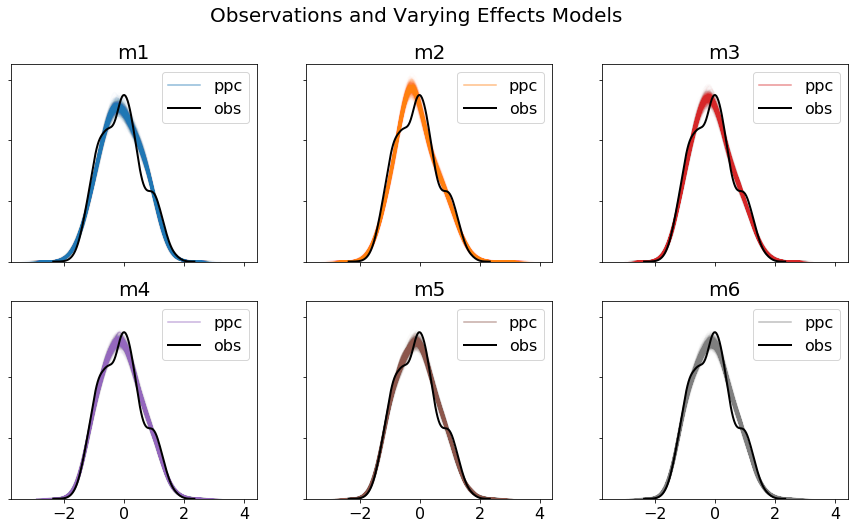

In [101]:
f, axs = pl.subplots(ncols=3, nrows=2, figsize=(15, 8), sharex=True, sharey=True)
ax = axs.ravel()
cm_ = cm.get_cmap('tab10')
cmh = [rgb2hex(cm_(i)[:3]) for i in [0, 1, 3, 4, 5, 7]]
for axi, (key, val), col_hex in zip(ax, ppc_dict.items(), cmh):
    axi.set_yticklabels([])
    axi.set_title(key)
    for i in range(val.shape[0]):
        if i == 0:
            kdeplot(val[i], color=col_hex, alpha=0.5, ax=axi, label='ppc')
        else:
            kdeplot(val[i], color=col_hex, alpha=0.01, ax=axi)

    kdeplot(log_chl_obs, ax=axi, linewidth=2, color='k', label='obs')
f.suptitle('Observations and Varying Effects Models', fontsize=20)
f.savefig('./figJar/kdeDensComp.png', dpi=300, format='png')

In [102]:
m1.name=  'm1: {pc1}'
m2.name = 'm2: {pc1, pc2}'
m3.name = 'm3: {pc1 ... 3}'
m4.name = 'm4: {pc1 ... 4}'
m5.name = 'm5: {pc1 ... 5}'
m6.name = 'm6: {pc1 ... 6}'

In [103]:
dfcomp = pm.compare({m1: trace_m1, m2: trace_m2, m3: trace_m3,
                    m4: trace_m4, m5: trace_m5, m6: trace_m6})
dfcomp

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """

WAIC   pWAIC    dWAIC weight      SE     dSE var_warn
m5: {pc1 ... 5}  -385.53  105.48        0   0.95   137.2       0        1
m6: {pc1 ... 6}  -380.81  108.43     4.72      0  137.41    2.08        1
m4: {pc1 ... 4}  -195.32   85.34   190.21      0  121.54   40.43        1
m3: {pc1 ... 3}   164.97    67.8    550.5   0.01  127.62   62.06        1
m2: {pc1, pc2}   1302.25   47.92  1687.79      0  111.86  101.42        1
m1: {pc1}        2361.67   19.44  2747.21   0.03   85.41  128.27        1

In [104]:
dfcomp_loo = pm.compare({m1: trace_m1, m2: trace_m2, m3: trace_m3,
                        m4: trace_m4, m5: trace_m5, m6: trace_m6},
                        ic='LOO')
dfcomp_loo

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO    pLOO     dLOO weight      SE     dSE shape_warn
m5: {pc1 ... 5}  -379.62  108.44        0   0.95  137.38       0          1
m6: {pc1 ... 6}  -374.18  111.74     5.44      0  137.58    2.09          1
m4: {pc1 ... 4}  -190.57   87.72   189.06      0  121.66   40.49          1
m3: {pc1 ... 3}   168.06   69.35   547.68   0.01  127.65   62.11          1
m2: {pc1, pc2}   1303.39   48.49  1683.01      0  111.91  101.35          1
m1: {pc1}         2362.1   19.66  2741.73   0.03   85.42  128.39          0

In [106]:
df_pca_bn.

id            datetime         doy ProvCode                    Province  \
0  4045 1998-08-29 17:55:00  242.625000     ADCP  Alaska Downwelling Coastal   
1  4056 1998-09-02 15:52:00  246.491667     ADCP  Alaska Downwelling Coastal   
2  4057 1998-09-02 18:10:00  245.916667     ADCP  Alaska Downwelling Coastal   
3  5949 1997-10-12 23:38:00  286.591667     ADCP  Alaska Downwelling Coastal   
4  5950 1997-10-13 18:33:00  287.300000     ADCP  Alaska Downwelling Coastal   

   ProvIdx  etopo2  oisst    rrs411    rrs443    ...       rrs670       PC1  \
0        0    82.0  13.04  0.141165  0.172922    ...     0.035757  0.116059   
1        0    14.0  11.74  0.115446  0.151645    ...     0.042194  0.155281   
2        0   107.0  11.74  0.135983  0.167122    ...     0.035198  0.122107   
3        0   143.0   9.71  0.146573  0.175221    ...     0.025622  0.093613   
4        0   286.0   9.84  0.156534  0.189320    ...     0.018003  0.059926   

        PC2       PC3       PC4       PC5           PC6  is_hplc    chl  \
0 -0.024758 -0.014299 -0.017767  0.012560  4.396813e-16      0.0  2.077   
1 -0.038227 -0.012004 -0.009912  0.010131 -4.373741e-17      0.0  1.799   
2 -0.032006 -0.012648 -0.014846  0.007807 -2.682333e-16      0.0  1.608   
3 -0.048046 -0.006094 -0.007291  0.006180  3.038692e-17      0.0  1.579   
4 -0.062310  0.006346 -0.004805  0.003131  9.842956e-17      0.0  1.074   

      chl_l  
0  0.317436  
1  0.255031  
2  0.206286  
3  0.198382  
4  0.031004  

[5 rows x 23 columns]

Modification to Province strings

In [ ]:

df_pca_bn.Province.replace('Boreal Polar Province (Polr)', 'Boreal Polar Province',
                           inplace=True)
df_pca_bn.Province.replace('Canary Coastal Province (Eacb)',
                           'Canary Coastal Province', inplace=True)
df_pca_bn.Province.replace('N. Atlantic Drift Province (Wwdr)', 
                           'N. Atlantic Drift Province', inplace=True)
df_pca_bn.Province.replace('N. Atlantic Subtropical Gyral Province (East) (Stge)',
                          'N. Atlantic Subtropical Gyral Province East', inplace=True)
df_pca_bn.Province.replace('N. Atlantic Subtropical Gyral Province (West) (Stgw)',
                          'N. Atlantic Subtropical Gyral Province West', inplace=True)
df_pca_bn.Province.replace('N. Atlantic Tropical Gyral Province (Trpg)',
                          'N. Atlantic Tropical Gyral Province', inplace=True)
df_pca_bn.Province.replace('N. Pacific Subtropical Gyre Province (West)', 
                          'N. Pacific Subtropical Gyre Province West', inplace=True)
df_pca_bn.Province.replace('Pacific Subarctic Gyres Province (East)', 
                          'Pacific Subarctic Gyres Province East', inplace=True)
df_pca_bn.Province.replace('South Atlantic Gyral Province (Satg)', 
                           'South Atlantic Gyral Province', inplace=True)

In [198]:
df_pca_bn.Province = df_pca_bn.Province.str.replace(' Province', '')

In [165]:
provcode = df_pca_bn.apply(lambda x: "".join(pat.findall(x['Province'])), axis=1)
df_pca_bn.insert(df_pca_bn.columns.get_loc('Province'), 
                'ProvCode', provcode)

In [109]:
province_names = df_pca_bn.Province.unique()

array(['Alaska Downwelling Coastal', 'Benguela Current Coastal',
       'Brazil Current Coastal', 'California Upwelling Coastal',
       'Canary Coastal', 'Chile-Peru Current Coastal',
       'China Sea Coastal', 'E. Africa Coastal', 'E. India Coastal',
       'Guianas Coastal', 'Ne Atlantic Shelves', 'New Zealand Coastal',
       'NW Arabian Upwelling', 'NW Atlantic Shelves',
       'Sunda-Arafura Shelves', 'SW Atlantic Shelves', 'Antarctic',
       'Atlantic Arctic', 'Atlantic Subarctic', 'Austral Polar',
       'Boreal Polar', 'N. Pacific Epicontinental', 'Caribbean',
       'Eastern Tropical Atlantic', 'Indian Monsoon Gyres',
       'Indian S. Subtropical Gyre', 'N. Atlantic Tropical Gyral',
       'N. Pacific Equatorial Countercurrent', 'N. Pacific Tropical Gyre',
       'Pacific Equatorial Divergence', 'South Atlantic Gyral',
       'W. Pacific Warm Pool', 'Western Tropical Atlantic', 'Gulf Stream',
       'Kuroshio Current', 'Mediterranean Sea, Black Sea',
       'N. Atlantic Dr

In [108]:
pat = re.comp

45

In [91]:
d_ = pd.DataFrame(columns=['chl_l', 'PC1', 'pred_chl_l_mean', 'pred_chl_l_95lo', 
                   'pred_chl_l_95hi', 'ProvIdx'])
d_['chl_l'] = df_pca_bn.chl_l.values
d_['PC1'] = df_pca_bn.PC1.values
d_['ProvIdx'] = df_pca_bn.ProvIdx

In [107]:
ppc_log_chl_m0 = pm.sample_ppc(trace_m0,
                                 samples=1000, model=m0)['log_chl']

100%|██████████| 1000/1000 [00:00<00:00, 1070.61it/s]


In [102]:
ppc_log_chl_m0.mean(axis=0)

(1000, 3311)

In [108]:
d_['pred_chl_l_mean'] = ppc_log_chl_m0.mean(axis=0)
hpd_ppc_log_chl_m0 = pm.hpd(ppc_log_chl_m0)
d_['pred_chl_l_95lo'] = hpd_ppc_log_chl_m0[:, 0]
d_['pred_chl_l_95hi'] = hpd_ppc_log_chl_m0[:, 1]
#del ppc_log_chl_m0, hpd_ppc_log_chl_m0

In [112]:
d_.head()

chl_l       PC1  pred_chl_l_mean  pred_chl_l_95lo  pred_chl_l_95hi  \
0  0.317436  0.116059         0.232137        -0.219415         0.719191   
1  0.255031  0.155281         0.418187        -0.047438         0.886311   
2  0.206286  0.122107         0.278514        -0.195651         0.730426   
3  0.198382  0.093613         0.163077        -0.265062         0.572106   
4  0.031004  0.059926         0.010117        -0.480172         0.412054   

   ProvIdx  
0        0  
1        0  
2        0  
3        0  
4        0

In [235]:
b = np.c_[trace_m0['b1'][:, i], trace_m0['b2'][:, i], trace_m0['b3'][:, i],
              trace_m0['b4'][:, i], trace_m0['b5'][:, i], trace_m0['b6'][:, i]]

In [239]:
z = df_pca_bn.loc[df_pca_bn.ProvIdx==i, ['PC%d' %j for j in range(1, 7)]].as_matrix().T

In [244]:
a_  = trace_m0['a'][:, i]

In [250]:
a_.reshape(-1,1) + b_

array([[-188.97690443, -188.98651184, -188.97324177, ..., -188.80390391,
        -188.97507047, -188.96573178],
       [ -72.60635324,  -72.61466769,  -72.60320323, ...,  -72.45701339,
         -72.60515975,  -72.5975411 ],
       [  66.14591593,   66.13742557,   66.14795741, ...,   66.30835352,
          66.14671513,   66.15422926],
       ...,
       [  44.48231002,   44.47201667,   44.48627284, ...,   44.66453403,
          44.48389369,   44.4936279 ],
       [  54.44966492,   54.44150766,   54.45195147, ...,   54.60733667,
          54.45085026,   54.45857049],
       [ -46.49298742,  -46.50137405,  -46.48887012, ...,  -46.35242531,
         -46.49122002,  -46.48307679]])

In [288]:
def shorten_string(prov_str):
    prov_str_lst = prov_str.split(' ')
    if len(prov_str_lst) == 1:
        ttl_str = prov_str_lst[0]
    else:
        new_lst = []
        for word in prov_str_lst:
            if len(word)>4:
                word = word[:4] + '.'
            new_lst.append(word)
        ttl_str = " ".join(new_lst)
    return ttl_str


def compute_mdl_mean(trace, i, df_):
    b = np.c_[trace['b1'][:, i].mean(), trace['b2'][:, i].mean(),
              trace['b3'][:, i].mean(), trace['b4'][:, i].mean(),
              trace['b5'][:, i].mean(), trace['b6'][:, i].mean()]
    mu_ = b.dot(df_.loc[df_.ProvIdx==i,
                        ['PC%d' %j for j in range(1, 7)]
                       ].as_matrix().T)
    return mu_.flatten()

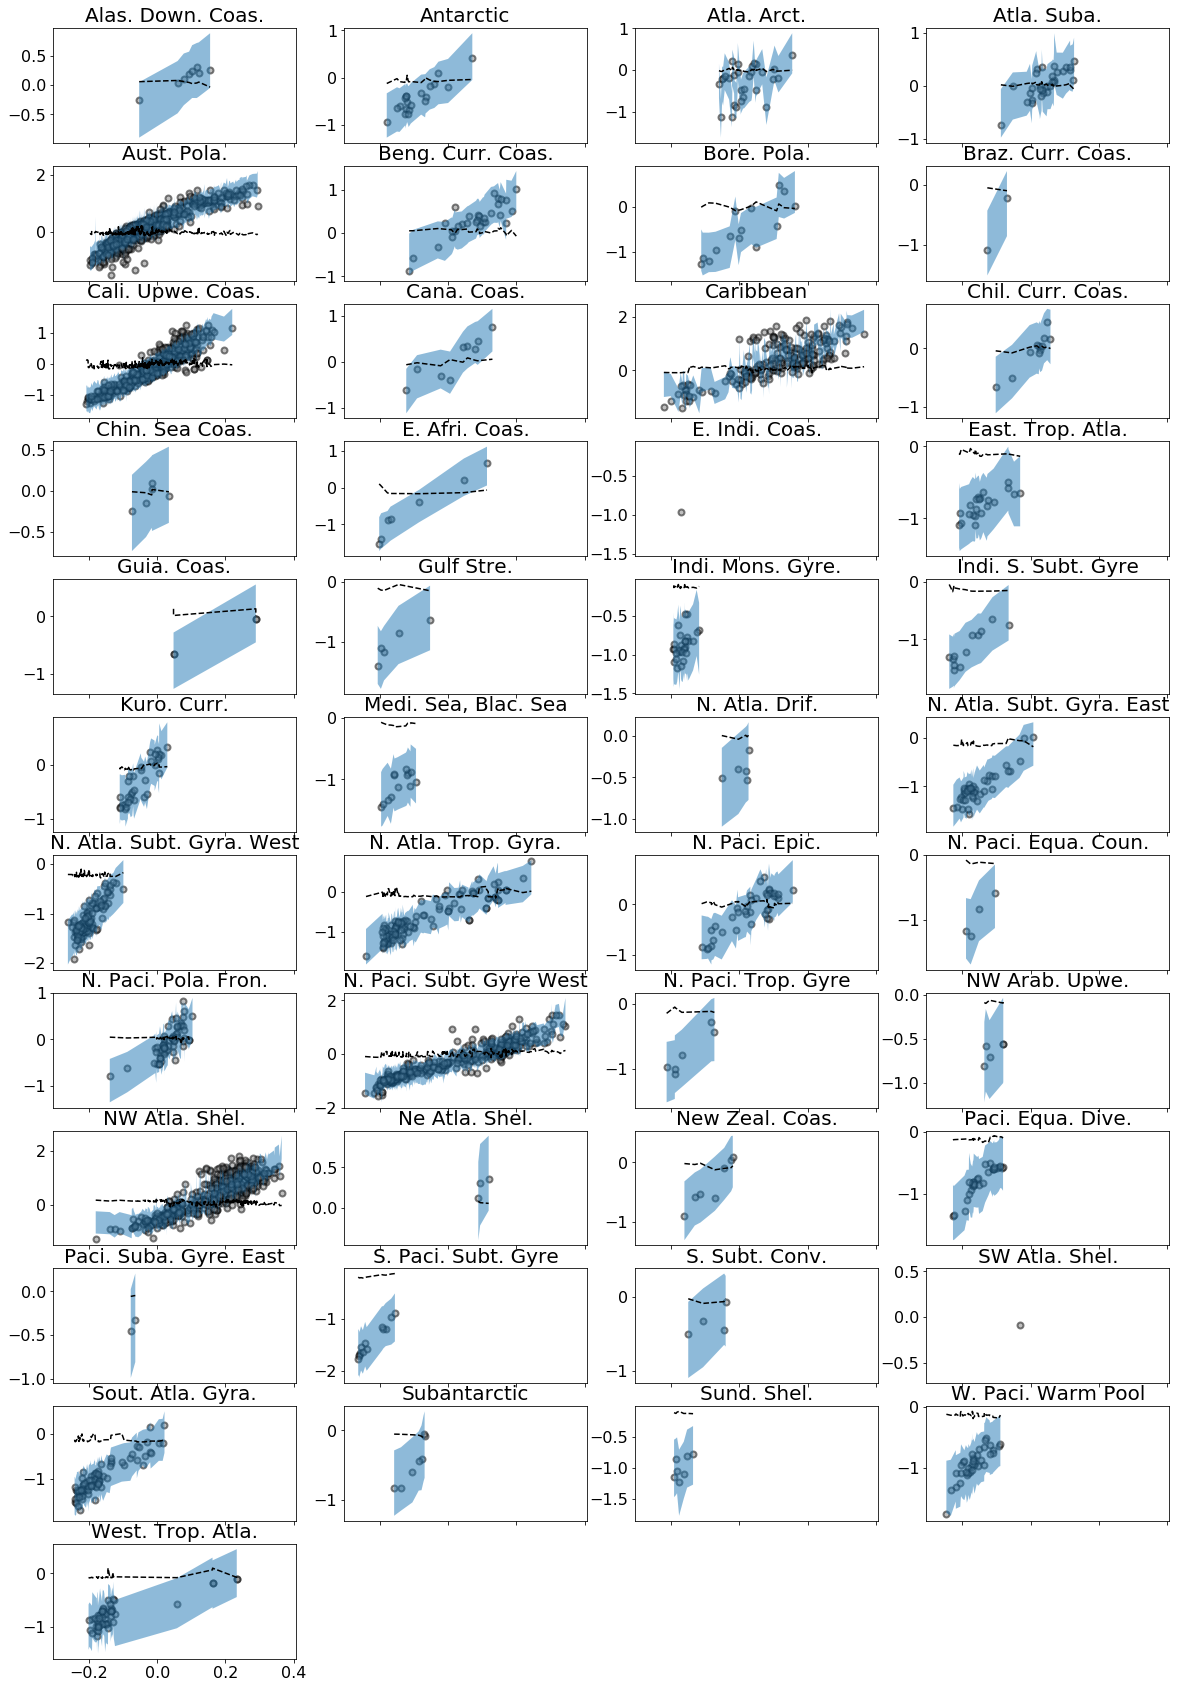

In [289]:
_, axs = pl.subplots(nrows=12, ncols=4, figsize=(20, 30), sharex=True)
ax = axs.ravel()
for i, prov in prov_mapping.items():
    xy = d_.loc[d_.ProvIdx==i, ['PC1', 'pred_chl_l_mean',
                                'pred_chl_l_95lo', 
                                'pred_chl_l_95hi', 'chl_l']].values
    ix = np.argsort(xy[:, 0])
    ax[i].scatter(xy[:, 0], xy[:, -1], facecolor='gray', edgecolor='k',
                  alpha=0.5, linewidth=2)
    title_string = shorten_string(prov)
    ax[i].set_title(title_string)
    mu_ = compute_mdl_mean(trace_m0, i, df_pca_bn)
    ax[i].plot(xy[ix, 0], mu_, 'k--')
    ax[i].fill_between(xy[ix, 0], xy[ix, 2], xy[ix, 3], alpha=0.5)
ax[45].set_visible(False)
ax[46].set_visible(False)
ax[47].set_visible(False)

In [ ]:
with pm.Model() as m_pca_cov:
    """Hierarchical MLR with covarying slope/intercept pairs"""